<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Получение-и-обработка-данных-о-границах-районов" data-toc-modified-id="Получение-и-обработка-данных-о-границах-районов-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Получение и обработка данных о границах районов</a></span><ul class="toc-item"><li><span><a href="#Источник-данных-границ-районов" data-toc-modified-id="Источник-данных-границ-районов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Источник данных границ районов</a></span></li><li><span><a href="#Запрос-на-границы-районов-Москвы" data-toc-modified-id="Запрос-на-границы-районов-Москвы-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Запрос на границы районов Москвы</a></span></li></ul></li><li><span><a href="#Получение-данных-о-поездках-в-такси-и-каршеринге-через-API" data-toc-modified-id="Получение-данных-о-поездках-в-такси-и-каршеринге-через-API-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Получение данных о поездках в такси и каршеринге через API</a></span></li><li><span><a href="#Обработка-данных" data-toc-modified-id="Обработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обработка данных</a></span></li><li><span><a href="#Добавление-координат" data-toc-modified-id="Добавление-координат-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Добавление координат</a></span></li><li><span><a href="#Добавление-данных-о-погоде" data-toc-modified-id="Добавление-данных-о-погоде-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Добавление данных о погоде</a></span></li><li><span><a href="#Обработка-названий-полей-и-пропусков-в-погодных-данных" data-toc-modified-id="Обработка-названий-полей-и-пропусков-в-погодных-данных-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обработка названий полей и пропусков в погодных данных</a></span></li><li><span><a href="#Выделение-новых-временных-признаков" data-toc-modified-id="Выделение-новых-временных-признаков-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выделение новых временных признаков</a></span></li><li><span><a href="#Добавление-данных-о-загруженности-метро" data-toc-modified-id="Добавление-данных-о-загруженности-метро-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Добавление данных о загруженности метро</a></span></li><li><span><a href="#Развлекательные-места-в-радиусе-5-км" data-toc-modified-id="Развлекательные-места-в-радиусе-5-км-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Развлекательные места в радиусе 5 км</a></span></li><li><span><a href="#Добавление-информации-о-населении-районов-и-доступности-метро" data-toc-modified-id="Добавление-информации-о-населении-районов-и-доступности-метро-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Добавление информации о населении районов и доступности метро</a></span></li><li><span><a href="#Цены-на-недвижимость-по-районам-Москвы" data-toc-modified-id="Цены-на-недвижимость-по-районам-Москвы-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Цены на недвижимость по районам Москвы</a></span></li><li><span><a href="#Добавление-административных-округов" data-toc-modified-id="Добавление-административных-округов-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Добавление административных округов</a></span></li></ul></div>

In [2]:
!pip install meteostat geopy

In [401]:
# Импортируемые библиотеки
import json
import pandas as pd
import requests
import time
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


from tqdm import tqdm
from datetime import datetime, timedelta
from meteostat import Hourly, Point
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

warnings.filterwarnings('ignore')

## Получение и обработка данных о границах районов

### Источник данных границ районов
**Источник:** [Overpass Turbo](https://overpass-turbo.eu/)

---
### Запрос на границы районов Москвы
```overpass
[out:json];
area[name="Москва"]->.boundary;
(
  relation["boundary"="administrative"]["admin_level"="8"](area.boundary);
);
out geom;
```

Выполняем запрос, затем делаем экспорт данных как GeoJSON, вручную меняем название на export_borders.geojson, сохраняем в рабочую директорию

In [12]:
path_borders = 'https://raw.githubusercontent.com/RuslanDavletov/Analysis-of-taxi-demand/main/data/export_borders.geojson'
path_centers = 'https://raw.githubusercontent.com/RuslanDavletov/Analysis-of-taxi-demand/main/data/export_centers.geojson'
path_stations = "https://raw.githubusercontent.com/RuslanDavletov/Analysis-of-taxi-demand/main/data/station_load_data_res%20(1).csv"

In [14]:
response = requests.get(path_borders)
data = response.json()

In [15]:
data_district = []

# Перебираем районы
for feature in data['features']:
    properties = feature['properties']
    geometry = feature['geometry']

    if geometry['type'] == 'MultiPolygon':
        for polygon in geometry['coordinates']:
            coords = [{'lng': point[0], 'lat': point[1]} for point in polygon[0]]
            district = {
                "type": "Polygon",
                "coordinates": [coords],
                "name": properties.get('name', 'Без названия'),
                "id": properties.get('@id', 'Неизвестно')
            }
            data_district.append(district)

    elif geometry['type'] == 'Polygon':
        coords = [{'lng': point[0], 'lat': point[1]} for point in geometry['coordinates'][0]]
        district = {
            "type": "Polygon",
            "coordinates": [coords],
            "name": properties.get('name', 'Без названия'),
            "id": properties.get('@id', 'Неизвестно')
        }
        data_district.append(district)


In [18]:
data_district

[{'type': 'Polygon',
  'coordinates': [[{'lng': 37.3786411, 'lat': 55.8083657},
    {'lng': 37.3793519, 'lat': 55.8091719},
    {'lng': 37.3804959, 'lat': 55.8090228},
    {'lng': 37.3806199, 'lat': 55.8093712},
    {'lng': 37.3849555, 'lat': 55.8090616},
    {'lng': 37.3850513, 'lat': 55.8093072},
    {'lng': 37.3823725, 'lat': 55.8095241},
    {'lng': 37.3807281, 'lat': 55.8096574},
    {'lng': 37.3810808, 'lat': 55.8106454},
    {'lng': 37.3808179, 'lat': 55.8106867},
    {'lng': 37.3796746, 'lat': 55.8106902},
    {'lng': 37.3800894, 'lat': 55.8111232},
    {'lng': 37.380221, 'lat': 55.8112671},
    {'lng': 37.3801967, 'lat': 55.8113191},
    {'lng': 37.3797576, 'lat': 55.8114726},
    {'lng': 37.379704, 'lat': 55.8114913},
    {'lng': 37.3794286, 'lat': 55.8115783},
    {'lng': 37.379299, 'lat': 55.8116193},
    {'lng': 37.3792076, 'lat': 55.8116482},
    {'lng': 37.3791905, 'lat': 55.8116582},
    {'lng': 37.3789377, 'lat': 55.8118067},
    {'lng': 37.3787066, 'lat': 55.8119424},

## Получение данных о поездках в такси и каршеринге через API

Источник - https://prodvizhenie.mos.ru

In [50]:
url = 'https://prodvizhenie.mos.ru/api/graphql'

headers = {
    'Content-Type': 'application/json',
    'User-Agent': 'Mozilla/5.0',
}

query = """
query GeometryStatsMapTooltip(
  $customGeometry: [[[Point!]]],
  $filter: Filter!,
  $source: DataSourceType!,
  $eventType: EventType!
) {
  currentPeriod: ridePolygonStats(
    ids: []
    customGeometry: $customGeometry
    filter: $filter
    source: $source
    aggregation: GEOMETRY
    eventType: $eventType
  ) {
    totalRideCount
    data {
      date
      hour
      rideCount
      __typename
    }
    __typename
  }
}
"""

In [52]:
def get_taxi_data(fromDate, toDate, coords, source, eventType):
    variables = {
        "filter": {
            "fromDate": fromDate,
            "toDate": toDate,
            "hours": [0, 23],
            "weekdays": [1, 2, 3, 4, 5, 6, 7]
        },
        "customGeometry": [coords],
        "source": f"{source}",
        "eventType": f"{eventType}"
    }

    response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)
    data = response.json()

    # Оставляем только полезные данные
    result = data.get('data', {}).get('currentPeriod', {})
    return {
        "totalRideCount": result.get('totalRideCount', 0),
        "rides": result.get('data', [])
    }

In [54]:
def get_df(start_date, end_date, source, event):
    main_df = pd.DataFrame()

    for i in tqdm(range(len(data_district)), desc="Обработка районов"):
        coords = data_district[i]['coordinates']
        get_json = get_taxi_data(start_date, end_date, coords, source, event)

        # Преобразование в DataFrame
        df = pd.DataFrame(get_json["rides"])

        # Добавим столбцы с информацией о районе
        df['district_name'] = data_district[i]['name']
        df['district_id'] = i

        main_df = pd.concat([main_df, df])

        # Задержка в 1 секунду
        time.sleep(1)
    return main_df

In [80]:
taxi_start = get_df("2024-01-01", "2024-12-31", 'TAXI', 'START')

Обработка районов: 100%|██████████████████████| 140/140 [11:00<00:00,  4.72s/it]


In [81]:
taxi_finish = get_df("2024-01-01", "2024-12-31", 'TAXI', 'FINISH')

Обработка районов: 100%|██████████████████████| 140/140 [10:55<00:00,  4.68s/it]


In [82]:
carsharing_start = get_df("2024-01-01", "2024-12-31", 'CARSHARING', 'START')

Обработка районов: 100%|██████████████████████| 140/140 [05:34<00:00,  2.39s/it]


In [83]:
carsharing_finish = get_df("2024-01-01", "2024-12-31", 'CARSHARING', 'FINISH')

Обработка районов: 100%|██████████████████████| 140/140 [06:16<00:00,  2.69s/it]


## Обработка данных

In [85]:
taxi_start.rename(columns={'rideCount': 'taxi_start_rideCount'}, inplace=True)
taxi_finish.rename(columns={'rideCount': 'taxi_finish_rideCount'}, inplace=True)
carsharing_start.rename(columns={'rideCount': 'carsharing_start_rideCount'}, inplace=True)
carsharing_finish.rename(columns={'rideCount': 'carsharing_finish_rideCount'}, inplace=True)

In [86]:
taxi_start.drop(columns=['__typename'], inplace=True)
taxi_finish.drop(columns=['__typename'], inplace=True)
carsharing_start.drop(columns=['__typename'], inplace=True)
carsharing_finish.drop(columns=['__typename'], inplace=True)

In [87]:
taxi_start['timestamp'] = pd.to_datetime(taxi_start['date']) + pd.to_timedelta(taxi_start['hour'], unit='h')
taxi_start.drop(columns=['date', 'hour'], inplace=True)

taxi_finish['timestamp'] = pd.to_datetime(taxi_finish['date']) + pd.to_timedelta(taxi_finish['hour'], unit='h')
taxi_finish.drop(columns=['date', 'hour'], inplace=True)

carsharing_start['timestamp'] = pd.to_datetime(carsharing_start['date']) + pd.to_timedelta(carsharing_start['hour'], unit='h')
carsharing_start.drop(columns=['date', 'hour'], inplace=True)

carsharing_finish['timestamp'] = pd.to_datetime(carsharing_finish['date']) + pd.to_timedelta(carsharing_finish['hour'], unit='h')
carsharing_finish.drop(columns=['date', 'hour'], inplace=True)

In [88]:
carsharing_finish.sample(5)

,carsharing_finish_rideCount,district_name,district_id,timestamp
662,27.0,Останкинский район,78,2024-01-28 14:00:00
6859,7.0,район Капотня,54,2024-10-30 06:00:00
7741,13.0,Академический район,109,2024-11-22 02:00:00
2301,61.0,район Люблино,53,2024-04-08 20:00:00
8615,17.0,район Бирюлёво Западное,70,2024-12-28 20:00:00


In [89]:
main_df = taxi_start.merge(taxi_finish, on=['district_id', 'district_name', 'timestamp'], how='outer')

In [90]:
main_df = main_df.merge(carsharing_start, on=['district_id', 'district_name', 'timestamp'], how='outer')

In [91]:
main_df = main_df.merge(carsharing_finish, on=['district_id', 'district_name', 'timestamp'], how='outer')

In [92]:
main_df.head()

,taxi_start_rideCount,district_name,district_id,timestamp,taxi_finish_rideCount,carsharing_start_rideCount,carsharing_finish_rideCount
0,8.0,район Кунцево,0,2024-01-01 00:00:00,4.0,NaN,NaN
1,11.0,район Кунцево,0,2024-01-01 01:00:00,11.0,1.0,1.0
2,7.0,район Кунцево,0,2024-01-01 02:00:00,7.0,NaN,NaN
3,12.0,район Кунцево,0,2024-01-01 03:00:00,8.0,NaN,NaN
4,5.0,район Кунцево,0,2024-01-01 04:00:00,6.0,NaN,NaN


In [93]:
main_df[['taxi_start_rideCount', 'taxi_finish_rideCount', 'carsharing_start_rideCount', 'carsharing_finish_rideCount']] = main_df[['taxi_start_rideCount', 'taxi_finish_rideCount', 'carsharing_start_rideCount', 'carsharing_finish_rideCount']].fillna(0)

In [94]:
main_df.groupby(['district_id']).timestamp.count()

district_id
0      8593
1      8691
2      8679
3      8241
4      4345
       ... 
135    8692
136    8690
137    8668
138    8669
139    8690
Name: timestamp, Length: 140, dtype: int64

In [95]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182194 entries, 0 to 1182193
Data columns (total 7 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   taxi_start_rideCount         1182194 non-null  float64       
 1   district_name                1182194 non-null  object        
 2   district_id                  1182194 non-null  int64         
 3   timestamp                    1182194 non-null  datetime64[ns]
 4   taxi_finish_rideCount        1182194 non-null  float64       
 5   carsharing_start_rideCount   1182194 non-null  float64       
 6   carsharing_finish_rideCount  1182194 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 63.1+ MB


In [96]:
main_df['timestamp'] = pd.to_datetime(main_df['timestamp'])

full_range = pd.date_range(start=main_df['timestamp'].min(),
                           end=main_df['timestamp'].max(),
                           freq='H')

districts = main_df[['district_name', 'district_id']].drop_duplicates()

full_df = (districts.assign(key=1)
           .merge(pd.DataFrame({'timestamp': full_range, 'key': 1}), on='key')
           .drop(columns='key'))

df_filled = (full_df.merge(main_df,
                           on=['timestamp', 'district_name', 'district_id'],
                           how='left')
                    .fillna(0))


In [97]:
df_filled

,district_name,district_id,timestamp,taxi_start_rideCount,taxi_finish_rideCount,carsharing_start_rideCount,carsharing_finish_rideCount
0,район Кунцево,0,2024-01-01 00:00:00,8.0,4.0,0.0,0.0
1,район Кунцево,0,2024-01-01 01:00:00,11.0,11.0,1.0,1.0
2,район Кунцево,0,2024-01-01 02:00:00,7.0,7.0,0.0,0.0
3,район Кунцево,0,2024-01-01 03:00:00,12.0,8.0,0.0,0.0
4,район Кунцево,0,2024-01-01 04:00:00,5.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...
1226395,Басманный район,139,2024-12-30 19:00:00,0.0,0.0,76.0,89.0
1226396,Басманный район,139,2024-12-30 20:00:00,0.0,0.0,91.0,74.0
1226397,Басманный район,139,2024-12-30 21:00:00,0.0,0.0,102.0,73.0
1226398,Басманный район,139,2024-12-30 22:00:00,0.0,0.0,68.0,53.0


In [98]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226400 entries, 0 to 1226399
Data columns (total 7 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   district_name                1226400 non-null  object        
 1   district_id                  1226400 non-null  int64         
 2   timestamp                    1226400 non-null  datetime64[ns]
 3   taxi_start_rideCount         1226400 non-null  float64       
 4   taxi_finish_rideCount        1226400 non-null  float64       
 5   carsharing_start_rideCount   1226400 non-null  float64       
 6   carsharing_finish_rideCount  1226400 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 65.5+ MB


In [99]:
# Проверка что количество регионов бьется с википедией (https://ru.wikipedia.org/wiki/Районы_Москвы)

df_filled.district_name.nunique()

132

In [130]:
df_time_grouped = df_filled.groupby(df_filled['timestamp'].dt.date)['taxi_start_rideCount'].sum()


In [144]:
mean_val = df_time_grouped.mean()
std_val = df_time_grouped.std()

# Определяем границы выбросо
lower_bound = mean_val - 2 * std_val
upper_bound = mean_val + 2 * std_val

# Выбираем даты, где значения выходят за границы
outliers = df_time_grouped[(df_time_grouped < lower_bound) | (df_time_grouped > upper_bound)]
outliers

timestamp
2024-01-14       2970.0
2024-02-02     504899.0
2024-02-03     453418.0
2024-02-04          0.0
2024-02-05          0.0
2024-02-06      56898.0
2024-06-19    2081001.0
2024-12-30          0.0
Name: taxi_start_rideCount, dtype: float64

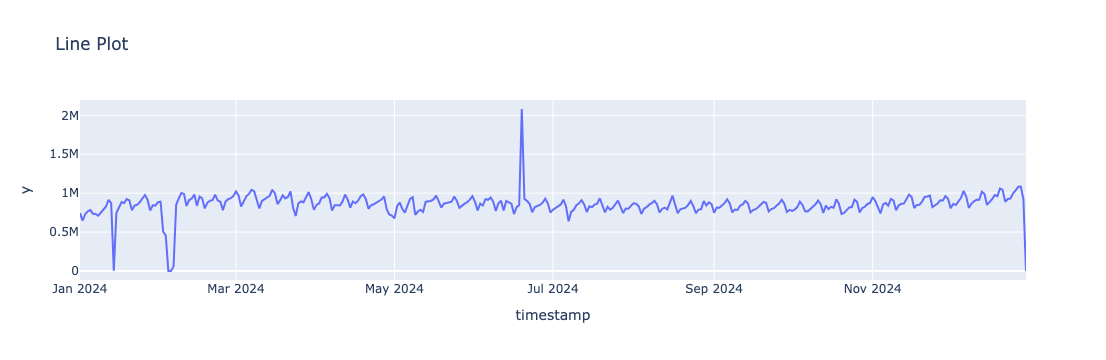

In [132]:
fig = px.line(df_time_grouped, x=df_time_grouped.index, y=df_time_grouped.values, title="Line Plot")

fig.show()

In [142]:
 # Добавляем столбцы month и hour для группировки
df_filled['month'] = df_filled['timestamp'].dt.month
df_filled['hour'] = df_filled['timestamp'].dt.hour

# Определяем медиану поездок по месяцам, часам и районам
median_values = df_filled.groupby(['month', 'hour', 'district_name'])['taxi_start_rideCount'].median()

outlier_dates = set(outliers.index)

# Функция для замены выбросов на медиану
def replace_outliers(row):
    if row['timestamp'].date() in outlier_dates:
        return median_values.get((row['month'], row['hour'], row['district_name']), row['taxi_start_rideCount'])
    return row['taxi_start_rideCount']

df_filled['taxi_start_rideCount'] = df_filled.apply(replace_outliers, axis=1)

In [146]:
df_time_grouped_check = df_filled.groupby(df_filled['timestamp'].dt.date)['taxi_start_rideCount'].sum()

In [150]:
mean_val = df_time_grouped_check.mean()
std_val = df_time_grouped_check.std()

# Определяем границы выбросо
lower_bound = mean_val - 3 * std_val
upper_bound = mean_val + 3 * std_val

# Выбираем даты, где значения выходят за границы
outliers = df_time_grouped_check[(df_time_grouped_check < lower_bound) | (df_time_grouped_check > upper_bound)]
outliers

Series([], Name: taxi_start_rideCount, dtype: float64)

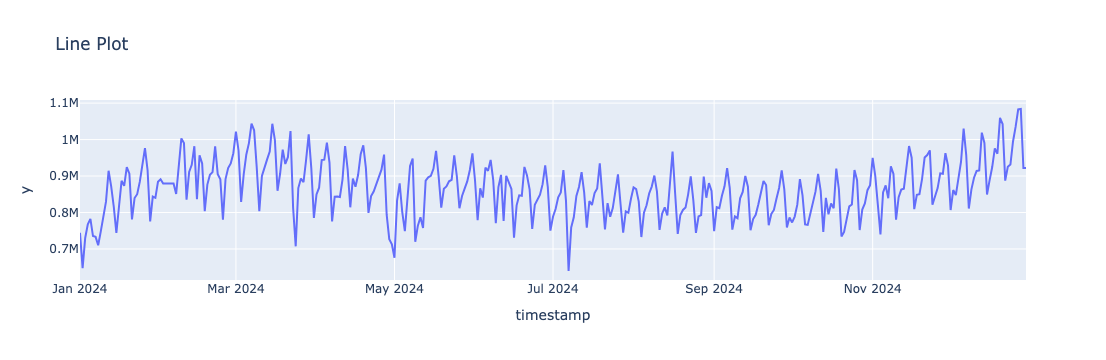

In [154]:
fig = px.line(df_time_grouped_check, x=df_time_grouped_check.index, y=df_time_grouped_check.values, title="Line Plot")

fig.show()

In [158]:
df_time_grouped = df_filled.groupby(df_filled['timestamp'].dt.date)['taxi_finish_rideCount'].sum()

In [160]:
mean_val = df_time_grouped.mean()
std_val = df_time_grouped.std()

# Определяем границы выбросо
lower_bound = mean_val - 2 * std_val
upper_bound = mean_val + 2 * std_val

# Выбираем даты, где значения выходят за границы
outliers = df_time_grouped[(df_time_grouped < lower_bound) | (df_time_grouped > upper_bound)]
outliers

timestamp
2024-01-14       2859.0
2024-02-02     499767.0
2024-02-03     451022.0
2024-02-04          0.0
2024-02-05          0.0
2024-02-06      53443.0
2024-06-19    2110543.0
2024-12-30          0.0
Name: taxi_finish_rideCount, dtype: float64

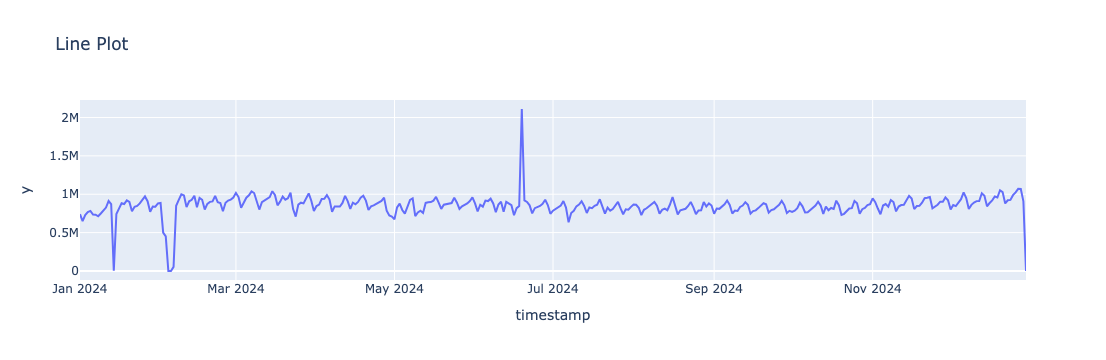

In [162]:
fig = px.line(df_time_grouped, x=df_time_grouped.index, y=df_time_grouped.values, title="Line Plot")

fig.show()

In [164]:
# Определяем медиану поездок по месяцам, часам и районам
median_values = df_filled.groupby(['month', 'hour', 'district_name'])['taxi_finish_rideCount'].median()

outlier_dates = set(outliers.index)

# Функция для замены выбросов на медиану
def replace_outliers(row):
    if row['timestamp'].date() in outlier_dates:
        return median_values.get((row['month'], row['hour'], row['district_name']), row['taxi_finish_rideCount'])
    return row['taxi_finish_rideCount']

df_filled['taxi_finish_rideCount'] = df_filled.apply(replace_outliers, axis=1)

In [166]:
df_filled.columns

Index(['district_name', 'district_id', 'timestamp', 'taxi_start_rideCount',
       'taxi_finish_rideCount', 'carsharing_start_rideCount',
       'carsharing_finish_rideCount', 'month', 'hour'],
      dtype='object')

In [200]:
df_time_grouped = df_filled.groupby(df_filled['timestamp'].dt.date)['carsharing_start_rideCount'].sum()
mean_val = df_time_grouped.mean()
std_val = df_time_grouped.std()

# Определяем границы выбросо
lower_bound = mean_val - 2.8 * std_val
upper_bound = mean_val + 2.8 * std_val

# Выбираем даты, где значения выходят за границы
outliers = df_time_grouped[(df_time_grouped < lower_bound) | (df_time_grouped > upper_bound)]
outliers

timestamp
2024-01-01     61652.0
2024-01-26     49965.0
2024-01-27     51346.0
2024-01-28     47676.0
2024-02-02     48248.0
2024-02-03     59307.0
2024-02-04         0.0
2024-02-05         0.0
2024-02-06      8694.0
2024-05-22     61048.0
2024-06-19    200357.0
Name: carsharing_start_rideCount, dtype: float64

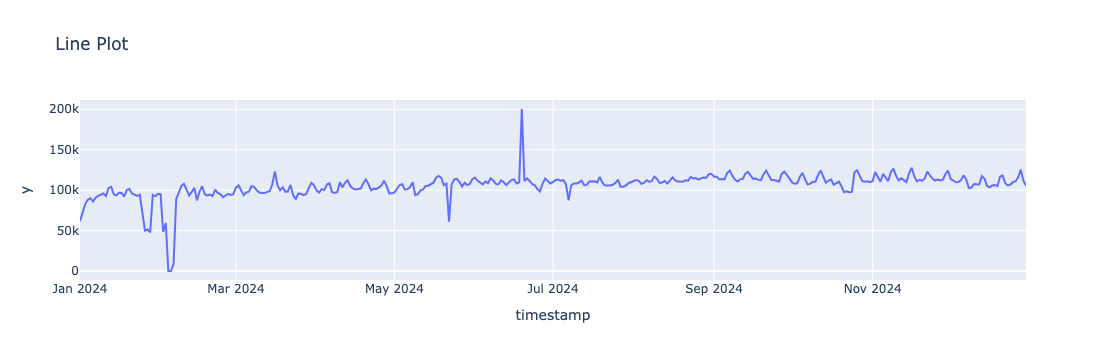

In [180]:
fig = px.line(df_time_grouped, x=df_time_grouped.index, y=df_time_grouped.values, title="Line Plot")

fig.show()

In [202]:
# Определяем медиану поездок по месяцам, часам и районам
median_values = df_filled.groupby(['month', 'hour', 'district_name'])['carsharing_start_rideCount'].median()

outlier_dates = set(outliers.index)

# Функция для замены выбросов на медиану
def replace_outliers(row):
    if row['timestamp'].date() in outlier_dates:
        return median_values.get((row['month'], row['hour'], row['district_name']), row['carsharing_start_rideCount'])
    return row['carsharing_start_rideCount']

df_filled['carsharing_start_rideCount'] = df_filled.apply(replace_outliers, axis=1)

In [204]:
df_time_grouped = df_filled.groupby(df_filled['timestamp'].dt.date)['carsharing_finish_rideCount'].sum()
mean_val = df_time_grouped.mean()
std_val = df_time_grouped.std()

# Определяем границы выбросо
lower_bound = mean_val - 2.8 * std_val
upper_bound = mean_val + 2.8 * std_val

# Выбираем даты, где значения выходят за границы
outliers = df_time_grouped[(df_time_grouped < lower_bound) | (df_time_grouped > upper_bound)]
outliers

timestamp
2024-01-01     62043.0
2024-01-26     50005.0
2024-01-27     51486.0
2024-01-28     47888.0
2024-02-02     49003.0
2024-02-03     60261.0
2024-02-04         0.0
2024-02-05         0.0
2024-02-06      8600.0
2024-06-19    196624.0
Name: carsharing_finish_rideCount, dtype: float64

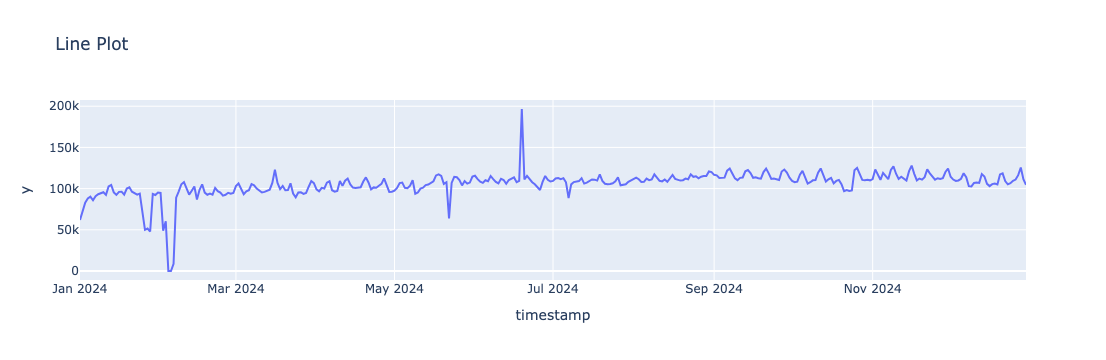

In [206]:
fig = px.line(df_time_grouped, x=df_time_grouped.index, y=df_time_grouped.values, title="Line Plot")

fig.show()

In [208]:
# Определяем медиану поездок по месяцам, часам и районам
median_values = df_filled.groupby(['month', 'hour', 'district_name'])['carsharing_finish_rideCount'].median()

outlier_dates = set(outliers.index)

# Функция для замены выбросов на медиану
def replace_outliers(row):
    if row['timestamp'].date() in outlier_dates:
        return median_values.get((row['month'], row['hour'], row['district_name']), row['carsharing_finish_rideCount'])
    return row['carsharing_finish_rideCount']

df_filled['carsharing_finish_rideCount'] = df_filled.apply(replace_outliers, axis=1)

In [218]:
df_filled.shape

(1226400, 9)

In [224]:
# Группирую по id района 
df_filled = df_filled.groupby(['district_name', 'timestamp'], as_index=False).agg({'taxi_start_rideCount': 'sum', 
                                                                       'taxi_finish_rideCount': 'sum',
                                                                       'carsharing_start_rideCount': 'sum',
                                                                       'carsharing_finish_rideCount': 'sum'})
                                                                       

## Добавление координат

Источник данных
**Источник:** [Overpass Turbo](https://overpass-turbo.eu/)

---
Запрос на центры районов Москвы
```overpass
[out:json];
area[name="Москва"]->.moscow;
relation["admin_level"="8"](area.moscow);
out center tags;
```
Экспорт geojson, название файла - export_centers.geojson

In [226]:
df_filled.head()

,district_name,timestamp,taxi_start_rideCount,taxi_finish_rideCount,carsharing_start_rideCount,carsharing_finish_rideCount
0,Академический район,2024-01-01 00:00:00,203.0,178.0,15.0,21.0
1,Академический район,2024-01-01 01:00:00,417.0,355.0,11.0,14.0
2,Академический район,2024-01-01 02:00:00,404.0,426.0,5.0,9.0
3,Академический район,2024-01-01 03:00:00,381.0,415.0,6.0,6.0
4,Академический район,2024-01-01 04:00:00,281.0,332.0,4.0,4.0


In [228]:
response_centeres = requests.get(path_centers)
data_centeres = response_centeres.json()

df = pd.json_normalize(data_centeres['features'])
df.head()

,type,id,properties.@id,properties.addr:country,properties.addr:region,properties.admin_level,properties.alt_name,properties.boundary,properties.description,properties.name,...,properties.name:de,properties.population,properties.name:it,properties.name:pt,properties.contact:website,properties.name:zh,properties.name:zh-Hans,properties.name:zh-Hant,properties.name:vi,properties.loc_name
0,Feature,relation/226927,relation/226927,RU,Москва,8,муниципальный округ Кунцево,administrative,район — административно-территориальная единиц...,район Кунцево,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Feature,relation/240229,relation/240229,RU,Москва,8,муниципальный округ Крылатское,administrative,район — административно-территориальная единиц...,район Крылатское,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Feature,relation/364001,relation/364001,NaN,NaN,8,муниципальный округ Мещанский,administrative,район — административно-территориальная единиц...,Мещанский район,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Feature,relation/364551,relation/364551,RU,NaN,8,муниципальный округ Сокольники,administrative,район — административно-территориальная единиц...,район Сокольники,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Feature,relation/380704,relation/380704,NaN,NaN,8,NaN,administrative,NaN,район Коммунарка,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [229]:
df.columns

Index(['type', 'id', 'properties.@id', 'properties.addr:country',
       'properties.addr:region', 'properties.admin_level',
       'properties.alt_name', 'properties.boundary', 'properties.description',
       'properties.name', 'properties.name:ca', 'properties.name:en',
       'properties.name:ru', 'properties.name:uk',
       'properties.official_status', 'properties.type', 'properties.wikidata',
       'properties.wikipedia', 'properties.@geometry', 'geometry.type',
       'geometry.coordinates', 'properties.name:be', 'properties.omkmo:code',
       'properties.omkte:code', 'properties.name:eo', 'properties.website',
       'properties.image', 'properties.name:de', 'properties.population',
       'properties.name:it', 'properties.name:pt',
       'properties.contact:website', 'properties.name:zh',
       'properties.name:zh-Hans', 'properties.name:zh-Hant',
       'properties.name:vi', 'properties.loc_name'],
      dtype='object')

In [232]:
df_main = df[['properties.name', 'geometry.coordinates']]

In [234]:
df_main = df_main.copy()
df_main['lat'] = df_main['geometry.coordinates'].apply(lambda x: x[1])
df_main['lon'] = df_main['geometry.coordinates'].apply(lambda x: x[0])
df_main.drop(columns=['geometry.coordinates'], inplace=True)

In [236]:
df_main.head()

,properties.name,lat,lon
0,район Кунцево,55.758995,37.167845
1,район Крылатское,55.761077,37.415025
2,Мещанский район,55.778081,37.628645
3,район Сокольники,55.803140,37.677806
4,район Коммунарка,55.567655,37.461537


In [238]:
df_main.columns = ['district_name', 'lat', 'lon']

In [240]:
df_with_coords = df_filled.merge(df_main, how='left', on='district_name')

In [248]:
df_with_coords.isna().sum().sum()

0

In [250]:
df_with_coords.sample(3)

,district_name,timestamp,taxi_start_rideCount,taxi_finish_rideCount,carsharing_start_rideCount,carsharing_finish_rideCount,lat,lon
693899,район Матушкино,2024-03-18 11:00:00,142.0,137.0,5.0,3.0,56.002800,37.205145
245501,Савёловский район,2024-01-10 05:00:00,30.0,36.0,3.0,7.0,55.799849,37.567495
149032,Мещанский район,2024-01-05 16:00:00,728.0,763.0,61.0,52.0,55.778081,37.628645


## Добавление данных о погоде

In [252]:
df_with_coords.head()

,district_name,timestamp,taxi_start_rideCount,taxi_finish_rideCount,carsharing_start_rideCount,carsharing_finish_rideCount,lat,lon
0,Академический район,2024-01-01 00:00:00,203.0,178.0,15.0,21.0,55.689537,37.576881
1,Академический район,2024-01-01 01:00:00,417.0,355.0,11.0,14.0,55.689537,37.576881
2,Академический район,2024-01-01 02:00:00,404.0,426.0,5.0,9.0,55.689537,37.576881
3,Академический район,2024-01-01 03:00:00,381.0,415.0,6.0,6.0,55.689537,37.576881
4,Академический район,2024-01-01 04:00:00,281.0,332.0,4.0,4.0,55.689537,37.576881


In [254]:
df_with_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156320 entries, 0 to 1156319
Data columns (total 8 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   district_name                1156320 non-null  object        
 1   timestamp                    1156320 non-null  datetime64[ns]
 2   taxi_start_rideCount         1156320 non-null  float64       
 3   taxi_finish_rideCount        1156320 non-null  float64       
 4   carsharing_start_rideCount   1156320 non-null  float64       
 5   carsharing_finish_rideCount  1156320 non-null  float64       
 6   lat                          1156320 non-null  float64       
 7   lon                          1156320 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 70.6+ MB


In [256]:
# Переводим столбец timestamp в формат datetime
df_with_coords["timestamp"] = pd.to_datetime(df_with_coords["timestamp"])

# Получаем уникальные пары координат
unique_points = df_with_coords[["lat", "lon"]].drop_duplicates()

# Словарь для хранения погодных данных по координатам
weather_data_all = []

start = df_with_coords["timestamp"].min()
end = df_with_coords["timestamp"].max()

# Получаем погодные данные для каждой уникальной точки
for _, row in tqdm(unique_points.iterrows(), total=len(unique_points)):
    point = Point(row["lat"], row["lon"])
    data = Hourly(point, start, end).fetch().reset_index()

    # Добавляем координаты для последующего объединения
    data["lat"] = row["lat"]
    data["lon"] = row["lon"]

    # Оставляем только нужные столбцы
    data = data[["time", "lat", "lon", "temp", "prcp", "rhum", "wspd", "coco"]]
    data = data.rename(columns={"time": "timestamp"})

    weather_data_all.append(data)

# Объединяем все погодные данные в один датафрейм
weather_df = pd.concat(weather_data_all, ignore_index=True)

100%|█████████████████████████████████████████| 132/132 [00:08<00:00, 16.19it/s]


In [258]:
weather_df

,timestamp,lat,lon,temp,prcp,rhum,wspd,coco
0,2024-01-01 00:00:00,55.689537,37.576881,-11.1,0.0,68.0,11.0,4.0
1,2024-01-01 01:00:00,55.689537,37.576881,-12.0,0.0,75.0,7.4,4.0
2,2024-01-01 02:00:00,55.689537,37.576881,-12.4,0.0,76.0,5.5,4.0
3,2024-01-01 03:00:00,55.689537,37.576881,-12.1,0.0,73.0,11.0,4.0
4,2024-01-01 04:00:00,55.689537,37.576881,-12.7,0.0,70.0,7.4,14.0
...,...,...,...,...,...,...,...,...
1156315,2024-12-30 19:00:00,55.615635,37.537104,1.7,0.2,94.0,26.3,12.0
1156316,2024-12-30 20:00:00,55.615635,37.537104,1.7,0.2,92.0,22.7,12.0
1156317,2024-12-30 21:00:00,55.615635,37.537104,1.7,0.0,93.0,19.4,3.0
1156318,2024-12-30 22:00:00,55.615635,37.537104,1.1,0.0,92.0,16.6,3.0


In [260]:
ready_df = df_with_coords.merge(weather_df, how='left', on=["timestamp", "lat", "lon"])

In [262]:
ready_df.isna().sum().sum()

34092

## Обработка названий полей и пропусков в погодных данных

In [264]:
ready_df.rename(columns={'temp': 'temperature',
                         'prcp': 'precipitation',
                         'rhum': 'humidity',
                         'wspd': 'wind_speed',
                         'taxi_start_rideCount': 'n_taxi_start',
                         'taxi_finish_rideCount': 'n_taxi_end',
                         'carsharing_start_rideCount': 'n_carsharing_start',
                         'carsharing_finish_rideCount': 'n_carsharing_end',
                        'coco': 'weather_code'
                        }, inplace=True)

In [268]:
# задал порядок полей

ready_df = ready_df[['timestamp', 'district_name', 'lat', 'lon', 'n_taxi_start', 'n_taxi_end', \
'n_carsharing_start','n_carsharing_end', 'temperature','precipitation','humidity','wind_speed','weather_code']]

In [270]:
ready_df.sample(3)

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,humidity,wind_speed,weather_code
1064899,2024-07-24 19:00:00,район Чертаново Северное,55.632998,37.604067,197.0,197.0,34.0,30.0,18.4,0.0,71.0,7.6,1.0
285961,2024-08-23 01:00:00,Тропарёво-Никулино,55.661381,37.469488,146.0,167.0,13.0,17.0,15.0,0.0,77.0,7.2,1.0
202057,2024-01-25 01:00:00,Обручевский район,55.657953,37.518797,117.0,127.0,9.0,11.0,0.0,0.0,86.0,18.0,3.0


In [272]:
ready_df.isnull().sum()

timestamp                 0
district_name             0
lat                       0
lon                       0
n_taxi_start              0
n_taxi_end                0
n_carsharing_start        0
n_carsharing_end          0
temperature               0
precipitation         31852
humidity                  0
wind_speed                0
weather_code           2240
dtype: int64

In [274]:
# Пропуски были по timestamp, а не по координатам, поэтому заполнил последним известным precipitation
ready_df['precipitation'] = ready_df['precipitation'].ffill()

In [276]:
ready_df['weather_code'] = ready_df['weather_code'].ffill()

## Выделение новых временных признаков

In [278]:
ready_df.head()

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,humidity,wind_speed,weather_code
0,2024-01-01 00:00:00,Академический район,55.689537,37.576881,203.0,178.0,15.0,21.0,-11.1,0.0,68.0,11.0,4.0
1,2024-01-01 01:00:00,Академический район,55.689537,37.576881,417.0,355.0,11.0,14.0,-12.0,0.0,75.0,7.4,4.0
2,2024-01-01 02:00:00,Академический район,55.689537,37.576881,404.0,426.0,5.0,9.0,-12.4,0.0,76.0,5.5,4.0
3,2024-01-01 03:00:00,Академический район,55.689537,37.576881,381.0,415.0,6.0,6.0,-12.1,0.0,73.0,11.0,4.0
4,2024-01-01 04:00:00,Академический район,55.689537,37.576881,281.0,332.0,4.0,4.0,-12.7,0.0,70.0,7.4,14.0


In [280]:
ready_df.shape

(1156320, 13)

In [282]:
# Категориальный признак утренний / вечерний час пик
def classify_rush_hour(timestamp):
    hour = timestamp.hour
    if 7 <= hour < 10:
        return 1
    elif 17 <= hour < 20:
        return 2
    else:
        return 0

In [284]:
ready_df['rush_hour'] = ready_df['timestamp'].apply(classify_rush_hour)

In [285]:
def get_season(timestamp):
    month = timestamp.month
    if month in [12, 1, 2]:
        return 0  # Зима
    elif month in [3, 4, 5]:
        return 1  # Весна
    elif month in [6, 7, 8]:
        return 2  # Лето
    else:
        return 3  # Осень

In [286]:
ready_df['season'] = ready_df['timestamp'].apply(get_season)

In [287]:
# Убрал 1 января 2025, чтобы не было ошибок с другими признаками

ready_df = ready_df[ready_df['timestamp'].dt.year == 2024]

In [292]:
# Российские праздники
russian_holidays = [
    "2024-01-01", "2024-01-02", "2024-01-03", "2024-01-04", "2024-01-05", "2024-01-06", "2024-01-07", "2024-01-08",  # Новогодние праздники и Рождество
    "2024-02-23",  # День защитника Отечества
    "2024-03-08",  # Международный женский день
    "2024-05-01",  # Праздник Весны и Труда
    "2024-05-09",  # День Победы
    "2024-05-10",  # День Победы
    "2024-06-12",  # День России
    "2024-11-04",  # Новогодние праздники
    "2024-12-30",  # Новогодние праздники
    "2024-12-31",  # Новогодние праздники
]
russian_holidays = pd.to_datetime(russian_holidays)

In [294]:
def is_holiday_or_weekend(timestamp):
    return 1 if (timestamp.weekday() >= 5 or timestamp.date() in russian_holidays.date) else 0

In [296]:
ready_df['is_holiday_or_weekend'] = ready_df['timestamp'].apply(is_holiday_or_weekend)

In [297]:
ready_df.sample(5)

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,humidity,wind_speed,weather_code,rush_hour,season,is_holiday_or_weekend
1146374,2024-11-11 14:00:00,район Якиманка,55.730038,37.601996,364.0,390.0,19.0,8.0,-0.1,0.0,77.0,1.8,4.0,0,3,0
504184,2024-07-21 16:00:00,район Зюзино,55.653803,37.588785,230.0,188.0,40.0,40.0,22.6,0.0,56.0,10.8,3.0,0,2,1
258048,2024-06-16 00:00:00,Таганский район,55.740297,37.665955,791.0,509.0,41.0,37.0,14.5,0.0,90.0,0.0,2.0,0,2,1
201523,2024-01-02 19:00:00,Обручевский район,55.657953,37.518797,356.0,314.0,30.0,40.0,-20.0,0.0,70.0,18.0,3.0,2,0,1
570965,2024-03-06 05:00:00,район Косино-Ухтомский,55.713929,37.890837,37.0,50.0,16.0,6.0,-7.9,0.0,72.0,3.7,1.0,0,1,0


## Добавление данных о загруженности метро

In [300]:
passazhiro_potok = 'https://raw.githubusercontent.com/RuslanDavletov/Analysis-of-taxi-demand/refs/heads/main/data/passazhiro_potok.csv'

In [302]:
data = pd.read_csv(passazhiro_potok, delimiter=';')

In [303]:
data

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id,Unnamed: 7
0,Станция метрополитена,Линия,Год,Квартал,Входы пассажиров,Выходы пассажиров,global_id,NaN
1,Митино,Арбатско-Покровская линия,2021,I квартал,1913498,1829031,1138975996,NaN
2,Волоколамская,Арбатско-Покровская линия,2021,I квартал,1236714,1222309,1138975997,NaN
3,Строгино,Арбатско-Покровская линия,2021,I квартал,1938816,1903731,1138975999,NaN
4,Крылатское,Арбатско-Покровская линия,2021,I квартал,1849616,1818208,1138976000,NaN
...,...,...,...,...,...,...,...,...
4616,Сокольники,Сокольническая линия,2024,IV квартал,1421034,1421201,2722109779,NaN
4617,Проспект Вернадского,Сокольническая линия,2024,IV квартал,2153181,2182033,2722109908,NaN
4618,Кунцевская,Филёвская линия,2024,IV квартал,598552,581954,2722110038,NaN
4619,Новаторская,Троицкая линия,2024,IV квартал,939764,935750,2722110186,NaN


In [306]:
data = data.drop(index=0)
data = data.drop(columns=["Unnamed: 7"])
data.head()

,NameOfStation,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id
1,Митино,Арбатско-Покровская линия,2021,I квартал,1913498,1829031,1138975996
2,Волоколамская,Арбатско-Покровская линия,2021,I квартал,1236714,1222309,1138975997
3,Строгино,Арбатско-Покровская линия,2021,I квартал,1938816,1903731,1138975999
4,Крылатское,Арбатско-Покровская линия,2021,I квартал,1849616,1818208,1138976000
5,Площадь Революции,Арбатско-Покровская линия,2021,I квартал,2324687,2319343,1138976008


In [308]:
data.dtypes

NameOfStation         object
Line                  object
Year                  object
Quarter               object
IncomingPassengers    object
OutgoingPassengers    object
global_id             object
dtype: object

Перевожу числовые данные в нормальный вид

In [311]:
data["Year"] = pd.to_numeric(data["Year"], errors="coerce")
data["IncomingPassengers"] = pd.to_numeric(data["IncomingPassengers"], errors="coerce")
data["OutgoingPassengers"] = pd.to_numeric(data["OutgoingPassengers"], errors="coerce")

data.dtypes

NameOfStation         object
Line                  object
Year                   int64
Quarter               object
IncomingPassengers     int64
OutgoingPassengers     int64
global_id             object
dtype: object

Логичнее будет смотреть на загруженность по году и кварталу одновременно

In [314]:
df = data.groupby(['Year', 'Quarter', "NameOfStation"])[['IncomingPassengers', 'OutgoingPassengers']].apply(lambda x: x['IncomingPassengers'] - x['OutgoingPassengers'])
df

Year  Quarter     NameOfStation            
2021  I квартал   Авиамоторная         498    -129423
                                       526          5
                  Автозаводская        230    -156546
                                       465     -50626
                  Академическая        77        1973
                                                ...  
2024  IV квартал  Юго-Западная         4509    -86239
                  Южная                4488     25344
                  Ясенево              4406     46624
                  Яхромская            4564     46636
                  улица Дмитриевского  4466      2644
Length: 4620, dtype: int64

In [315]:
grouped = data.groupby(['Year', 'Quarter', 'NameOfStation', 'Line']).agg(IncomingPassengers=('IncomingPassengers', 'sum'),
    OutgoingPassengers=('OutgoingPassengers', 'sum'))

grouped['PassengerDifference'] = grouped['IncomingPassengers'] - grouped['OutgoingPassengers']

grouped = grouped.reset_index()
grouped

,Year,Quarter,NameOfStation,Line,IncomingPassengers,OutgoingPassengers,PassengerDifference
0,2021,I квартал,Авиамоторная,Калининская линия,3013520,3142943,-129423
1,2021,I квартал,Авиамоторная,Некрасовская линия,361301,361296,5
2,2021,I квартал,Автозаводская,Замоскворецкая линия,2634591,2791137,-156546
3,2021,I квартал,Автозаводская,Московское центральное кольцо,376437,427063,-50626
4,2021,I квартал,Академическая,Калужско-Рижская линия,2383964,2381991,1973
...,...,...,...,...,...,...,...
4615,2024,IV квартал,Юго-Западная,Сокольническая линия,5305786,5392025,-86239
4616,2024,IV квартал,Южная,Серпуховско-Тимирязевская линия,2166038,2140694,25344
4617,2024,IV квартал,Ясенево,Калужско-Рижская линия,2875255,2828631,46624
4618,2024,IV квартал,Яхромская,Люблинско-Дмитровская линия,1764146,1717510,46636


Смотрю на выбросы и думаю что делать с ними

<Axes: ylabel='PassengerDifference'>

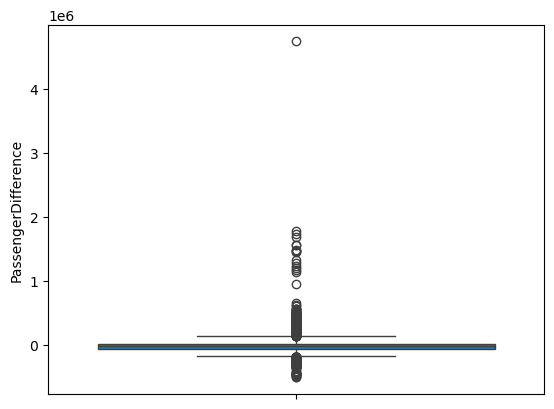

In [319]:
sns.boxplot(grouped["PassengerDifference"])

Прихожу к выводу, что просто удалить выбросы я не могу, поэтому написала функцию, в которой выбросы заменяются на медиану

In [322]:
def remove_outliers(group):
    median_ = group['PassengerDifference'].median()
    q1 = group['PassengerDifference'].quantile(0.25)
    q3 = group['PassengerDifference'].quantile(0.75)
    IQR = q3 - q1

    # границы для выбросов
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR

    #выбросы на медиану
    group['PassengerDifference'] = group['PassengerDifference'].apply(lambda x: median_ if x < lower or x > upper else x)
    return group

grouped = grouped.reset_index(drop=True)
cleaned = (grouped.groupby('Year').apply(remove_outliers).reset_index(drop=True))

cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('index')]

cleaned

,Year,Quarter,NameOfStation,Line,IncomingPassengers,OutgoingPassengers,PassengerDifference
0,2021,I квартал,Авиамоторная,Калининская линия,3013520,3142943,-129423.0
1,2021,I квартал,Авиамоторная,Некрасовская линия,361301,361296,5.0
2,2021,I квартал,Автозаводская,Замоскворецкая линия,2634591,2791137,-156546.0
3,2021,I квартал,Автозаводская,Московское центральное кольцо,376437,427063,-50626.0
4,2021,I квартал,Академическая,Калужско-Рижская линия,2383964,2381991,1973.0
...,...,...,...,...,...,...,...
4615,2024,IV квартал,Юго-Западная,Сокольническая линия,5305786,5392025,-86239.0
4616,2024,IV квартал,Южная,Серпуховско-Тимирязевская линия,2166038,2140694,25344.0
4617,2024,IV квартал,Ясенево,Калужско-Рижская линия,2875255,2828631,46624.0
4618,2024,IV квартал,Яхромская,Люблинско-Дмитровская линия,1764146,1717510,46636.0


Отберем данные за 2024 год

In [325]:
grouped = cleaned[cleaned['Year'] == 2024]
grouped

,Year,Quarter,NameOfStation,Line,IncomingPassengers,OutgoingPassengers,PassengerDifference
3411,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0
3412,2024,I квартал,Авиамоторная,Калининская линия,2837596,2971562,-133966.0
3413,2024,I квартал,Автозаводская,Замоскворецкая линия,3153491,3296201,-142710.0
3414,2024,I квартал,Автозаводская,Московское центральное кольцо,421776,463712,-41936.0
3415,2024,I квартал,Академическая,Калужско-Рижская линия,2798952,2832550,-33598.0
...,...,...,...,...,...,...,...
4615,2024,IV квартал,Юго-Западная,Сокольническая линия,5305786,5392025,-86239.0
4616,2024,IV квартал,Южная,Серпуховско-Тимирязевская линия,2166038,2140694,25344.0
4617,2024,IV квартал,Ясенево,Калужско-Рижская линия,2875255,2828631,46624.0
4618,2024,IV квартал,Яхромская,Люблинско-Дмитровская линия,1764146,1717510,46636.0


Добавим распределение по времени и правильное сопоставение кварталов

In [328]:
df = pd.DataFrame(grouped)

result_df = pd.DataFrame()

def add_dates_for_quarter(row):
    quarter = row['Quarter']
    if quarter == 'I квартал':
        date_range = pd.date_range(start='2024-01-01', end='2024-03-31 23:00:00', freq='h')
    elif quarter == 'II квартал':
        date_range = pd.date_range(start='2024-04-01', end='2024-06-30 23:00:00', freq='h')
    elif quarter == 'III квартал':
        date_range = pd.date_range(start='2024-07-01', end='2024-09-30 23:00:00', freq='h')
    elif quarter == 'IV квартал':
        date_range = pd.date_range(start='2024-10-01', end='2024-12-31 23:00:00', freq='h')

    time_df = pd.DataFrame(date_range, columns=['Timestamp'])

    for col in df.columns:
        time_df[col] = row[col]

    return time_df

for _, row in df.iterrows():
    result_df = pd.concat([result_df, add_dates_for_quarter(row)], ignore_index=True)

result_df

,Timestamp,Year,Quarter,NameOfStation,Line,IncomingPassengers,OutgoingPassengers,PassengerDifference
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0
...,...,...,...,...,...,...,...,...
2655115,2024-12-31 19:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0
2655116,2024-12-31 20:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0
2655117,2024-12-31 21:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0
2655118,2024-12-31 22:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0


Добавила DayOfWeek, чтобы понимать, какой день недели

In [330]:
result_df['DayOfWeek'] = pd.to_datetime(result_df['Timestamp']).dt.dayofweek

Теперь все праздники и каникулы

In [332]:
holidays_2024 = [
    '2024-01-01',
    '2024-01-07',
    '2024-02-23',
    '2024-03-08',
    '2024-05-01',
    '2024-05-09',
    '2024-06-12',
    '2024-11-04'
]


new_year_holidays = pd.date_range(start='2023-12-30', end='2024-01-08').strftime('%Y-%m-%d').tolist()

defender_day = pd.date_range(start='2024-02-23', end='2024-02-25').strftime('%Y-%m-%d').tolist()

womens_day = pd.date_range(start='2024-03-08', end='2024-03-10').strftime('%Y-%m-%d').tolist()

may_first = pd.date_range(start='2024-04-28', end='2024-05-01').strftime('%Y-%m-%d').tolist()

may_victory = pd.date_range(start='2024-05-09', end='2024-05-12').strftime('%Y-%m-%d').tolist()


unity_day = pd.date_range(start='2024-11-03', end='2024-11-04').strftime('%Y-%m-%d').tolist()

# Объединяем все длинные выходные
long_weekends = new_year_holidays + defender_day + womens_day + may_first + may_victory  + unity_day

transferred_holidays = [
    '2024-05-10',
    '2024-12-31',
    '2024-04-29',
    '2024-04-30',
    '2024-12-30'
]


all_holidays = list(set(holidays_2024 + long_weekends + transferred_holidays))

# Сортируем даты для удобства
all_holidays.sort()
all_holidays


result_df['Date'] = result_df['Timestamp'].dt.date

all_holidays_date = [pd.to_datetime(date).date() for date in all_holidays]

result_df['IsHoliday'] = result_df['Date'].isin(all_holidays_date)
result_df['Time'] = result_df['Timestamp'].dt.time

result_df

,Timestamp,Year,Quarter,NameOfStation,Line,IncomingPassengers,OutgoingPassengers,PassengerDifference,DayOfWeek,Date,IsHoliday,Time
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,00:00:00
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,01:00:00
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,02:00:00
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,03:00:00
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2655115,2024-12-31 19:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,19:00:00
2655116,2024-12-31 20:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,20:00:00
2655117,2024-12-31 21:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,21:00:00
2655118,2024-12-31 22:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,22:00:00


Основная логика такая: буду отталкиваться от уже известной загруженности метро поквартально, при этом домнажаяя ее на соотв коэфы в зависомсти от текущих признаков Теперь основные зависимости распишу тут:

1) Зависимость от времени, если это утро или вечер, то это пиковая загруженность, поэтому коэф самый высокий. Если это день, то загруженность средняя, если ночь, то она совсем маленькая(и соотв коэф-ы)

2)День недели, обычно в будни загруженность метро выше чем в выходные

3)Праздники, в праздники загруженность ниже чем в будни

4)Также попробовала сюда прицепить сезонность, но из проверенного тут только то, что зимой загруженность метро куда больше чем летом

Мы в каждой части считаем фактор зависимости, потом их складываем и домножаем на наш базовый коэф-т

In [334]:
def adjust_station_load(row):
    hour = row['Timestamp'].hour
    base_load = row['PassengerDifference']
    is_holiday = row['IsHoliday']
    day_of_week = row['Timestamp'].dayofweek
    month = row['Timestamp'].month

    #в зависимости от времени суток
    if 7 <= hour < 10:  # (пик)
        time_factor = 1.5
    elif 10 <= hour < 17:  # (средняя)
        time_factor = 1.0
    elif 17 <= hour < 21:  # (пик)
        time_factor = 1.5
    else:  #(низкая)
        time_factor = 0.5

    #день недели
    if day_of_week >= 5:  # Выходные
        day_factor = 0.8
    else:
        day_factor = 1.0  # Будни

    # праздники
    if is_holiday:
        holiday_factor = 0.7
    else:
        holiday_factor = 1.0

    #сезонность
    if month in [12, 1, 2]:  # Зима
        season_factor = 1.2
    elif month in [6, 7, 8]:  # Лето
        season_factor = 0.9
    else:
        season_factor = 1.0  # Другие месяцы

    # Итоговый коэффициент
    total_factor = time_factor * day_factor * holiday_factor * season_factor

    # Применяем коэффициент к базовой загруженности, где базовая загруженность - это поквартальная загруженность, от которой я отталкиваюсь
    adjusted_load = base_load * total_factor

    return adjusted_load

result_df['station_load'] = result_df.apply(adjust_station_load, axis=1)
result_df

,Timestamp,Year,Quarter,NameOfStation,Line,IncomingPassengers,OutgoingPassengers,PassengerDifference,DayOfWeek,Date,IsHoliday,Time,station_load
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,00:00:00,-46492.32
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,01:00:00,-46492.32
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,02:00:00,-46492.32
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,03:00:00,-46492.32
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,04:00:00,-46492.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655115,2024-12-31 19:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,19:00:00,3331.44
2655116,2024-12-31 20:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,20:00:00,3331.44
2655117,2024-12-31 21:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,21:00:00,1110.48
2655118,2024-12-31 22:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,22:00:00,1110.48


Теперь встает вопрос о нормализации данных, пользуюсь min-max нормализацией, чтобы данные были в пределах 0 и 1 для дальнейшей оценки загруженности Почемц не zскор - у него нет границ, поэтому такая нормализация не даст нам нормальной картины

In [336]:
def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

result_df['station_load_norm'] = result_df.groupby(['Year', 'Quarter'])['station_load'].transform(min_max_normalize)
result_df

,Timestamp,Year,Quarter,NameOfStation,Line,IncomingPassengers,OutgoingPassengers,PassengerDifference,DayOfWeek,Date,IsHoliday,Time,station_load,station_load_norm
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,00:00:00,-46492.32,0.456333
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,01:00:00,-46492.32,0.456333
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,02:00:00,-46492.32,0.456333
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,03:00:00,-46492.32,0.456333
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,04:00:00,-46492.32,0.456333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655115,2024-12-31 19:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,19:00:00,3331.44,0.560399
2655116,2024-12-31 20:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,20:00:00,3331.44,0.560399
2655117,2024-12-31 21:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,21:00:00,1110.48,0.556552
2655118,2024-12-31 22:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,22:00:00,1110.48,0.556552


In [337]:
import matplotlib.pyplot as plt

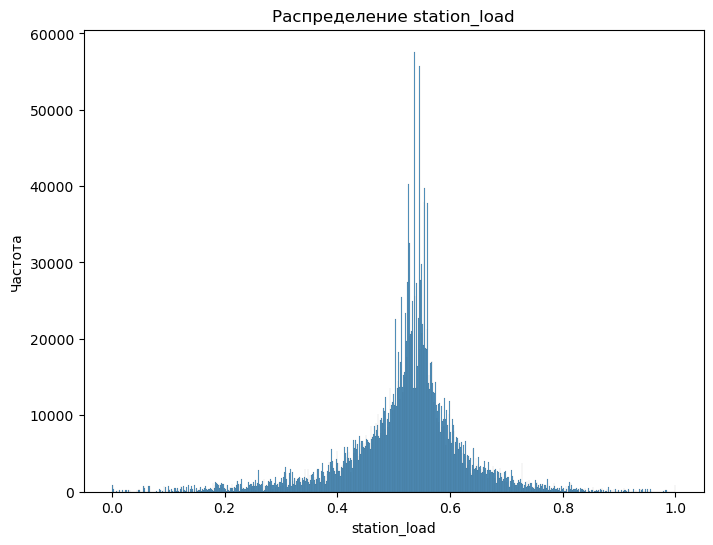

In [338]:
plt.figure(figsize=(8, 6))
sns.histplot(data=result_df, x='station_load_norm')

plt.title('Распределение station_load')
plt.xlabel('station_load')
plt.ylabel('Частота')
plt.show()

Для того чтобы оценить загруженность, пользуюсь pd.qcut, как раз разбивая на 5 примерно равных по количеству данных бинов

In [347]:
res = result_df.copy()
res["StationLoad"] = pd.cut(res['station_load_norm'], bins=10, labels=False) + 1
#bin_edges = pd.qcut(grouped['PassengerDifference_minmax'], q=5, retbins=True)[1]
res

,Timestamp,Year,Quarter,NameOfStation,Line,IncomingPassengers,OutgoingPassengers,PassengerDifference,DayOfWeek,Date,IsHoliday,Time,station_load,station_load_norm,StationLoad
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,00:00:00,-46492.32,0.456333,5
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,01:00:00,-46492.32,0.456333,5
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,02:00:00,-46492.32,0.456333,5
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,03:00:00,-46492.32,0.456333,5
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,1042435,1153131,-110696.0,0,2024-01-01,True,04:00:00,-46492.32,0.456333,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655115,2024-12-31 19:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,19:00:00,3331.44,0.560399,6
2655116,2024-12-31 20:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,20:00:00,3331.44,0.560399,6
2655117,2024-12-31 21:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,21:00:00,1110.48,0.556552,6
2655118,2024-12-31 22:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,914038,911394,2644.0,1,2024-12-31,True,22:00:00,1110.48,0.556552,6


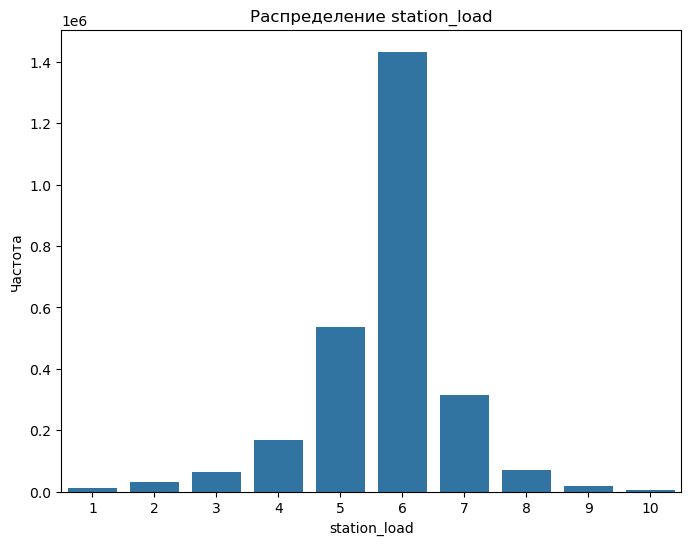

In [348]:
plt.figure(figsize=(8, 6))
sns.countplot(data=res, x='StationLoad')

plt.title('Распределение station_load')
plt.xlabel('station_load')
plt.ylabel('Частота')
plt.show()

Оставляю только то что нужно

In [350]:
result_data = res[['Timestamp', 'Year', 'Quarter', 'NameOfStation', 'Line', 'StationLoad', 'station_load_norm']].copy()

result_data.head()

,Timestamp,Year,Quarter,NameOfStation,Line,StationLoad,station_load_norm
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333


Теперь нужно добавить координаты для каждой стании метро, чтобы связать с нашим основным датасетом я обратилась к сайту Дадата, с помощью котрого спарсила все координаты для наших станций

In [352]:
stations = result_data['NameOfStation'].unique()
stations

array(['Авиамоторная', 'Автозаводская', 'Академическая',
       'Александровский сад', 'Алексеевская', 'Алма-Атинская',
       'Алтуфьево', 'Аминьевская', 'Андроновка', 'Аннино', 'Арбатская',
       'Аэропорт', 'Аэропорт Внуково', 'Бабушкинская', 'Багратионовская',
       'Балтийская', 'Баррикадная', 'Бауманская', 'Беговая',
       'Белокаменная', 'Беломорская', 'Белорусская', 'Беляево',
       'Бибирево', 'Библиотека имени Ленина', 'Битцевский парк',
       'Борисово', 'Боровицкая', 'Боровское шоссе', 'Ботанический сад',
       'Братиславская', 'Бульвар Дмитрия Донского',
       'Бульвар Рокоссовского', 'Бульвар адмирала Ушакова',
       'Бунинская аллея', 'Бутырская', 'ВДНХ', 'Варшавская',
       'Верхние Котлы', 'Верхние Лихоборы', 'Владыкино', 'Водный стадион',
       'Войковская', 'Волгоградский проспект', 'Волжская',
       'Волоколамская', 'Воробьёвы горы', 'Воронцовская',
       'Выставочный центр', 'Выхино', 'Говорово', 'Давыдково',
       'Деловой центр', 'Динамо', 'Дмитровск

In [353]:
api_key = 'a40d2661860b1e9d8786a09ed73fd143cbde7066'
url = "http://suggestions.dadata.ru/suggestions/api/4_1/rs/suggest/metro"

headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
    "Authorization": f"Token {api_key}"
}

def get_station_coordinates(station_name):
    data = {
        "query": station_name
    }
    response = requests.post(url, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        result = response.json()
        if result["suggestions"]:
            station_data = result["suggestions"][0]["data"]
            return station_data["geo_lat"], station_data["geo_lon"]
        else:
            print(f"Станция {station_name} не найдена.")
            return None, None

#хранение координат
coordinates_df = pd.DataFrame(columns=["Station", "Latitude", "Longitude"])

for station in stations:
    lat, lon = get_station_coordinates(station)
    if lat and lon:
        new_row = pd.DataFrame({"Station": [station], "Latitude": [lat], "Longitude": [lon]})
        coordinates_df = pd.concat([coordinates_df, new_row], ignore_index=True)

coordinates_df

,Station,Latitude,Longitude
0,Авиамоторная,55.751933,37.717444
1,Автозаводская,55.706634,37.657008
2,Академическая,55.687147,37.572300
3,Александровский сад,55.752255,37.608775
4,Алексеевская,55.807794,37.638699
...,...,...,...
258,Потапово,55.552664,37.493044
259,Тютчевская,55.617992,37.482444
260,Университет Дружбы Народов,55.649091,37.507300
261,Коммунарка,55.574599,37.467967


In [354]:
df_merged = result_data.merge(coordinates_df, left_on='NameOfStation', right_on='Station', how='left')
df_merged

,Timestamp,Year,Quarter,NameOfStation,Line,StationLoad,station_load_norm,Station,Latitude,Longitude
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333,Авиамоторная,55.751933,37.717444
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333,Авиамоторная,55.751933,37.717444
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333,Авиамоторная,55.751933,37.717444
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333,Авиамоторная,55.751933,37.717444
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,0.456333,Авиамоторная,55.751933,37.717444
...,...,...,...,...,...,...,...,...,...,...
2655115,2024-12-31 19:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,6,0.560399,улица Дмитриевского,55.710311,37.879045
2655116,2024-12-31 20:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,6,0.560399,улица Дмитриевского,55.710311,37.879045
2655117,2024-12-31 21:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,6,0.556552,улица Дмитриевского,55.710311,37.879045
2655118,2024-12-31 22:00:00,2024,IV квартал,улица Дмитриевского,Некрасовская линия,6,0.556552,улица Дмитриевского,55.710311,37.879045


In [356]:
df_merged.isna().sum()

Timestamp            0
Year                 0
Quarter              0
NameOfStation        0
Line                 0
StationLoad          0
station_load_norm    0
Station              0
Latitude             0
Longitude            0
dtype: int64

In [357]:
df_merged['NameOfStation'] = df_merged['NameOfStation'].apply(lambda x: '-'.join(word.capitalize() for word in x.split('-')))

new_data = df_merged[['Timestamp', 'Year', 'Quarter', 'NameOfStation', 'Line', 'StationLoad', 'Latitude', 'Longitude', 'station_load_norm']].copy()

In [358]:
new_data.head()

,Timestamp,Year,Quarter,NameOfStation,Line,StationLoad,Latitude,Longitude,station_load_norm
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333


In [359]:
#ready_df = pd.read_csv('main_df.csv')
#ready_df.head()

In [360]:
metro = new_data.copy()

In [361]:
metro

,Timestamp,Year,Quarter,NameOfStation,Line,StationLoad,Latitude,Longitude,station_load_norm
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333
...,...,...,...,...,...,...,...,...,...
2655115,2024-12-31 19:00:00,2024,IV квартал,Улица дмитриевского,Некрасовская линия,6,55.710311,37.879045,0.560399
2655116,2024-12-31 20:00:00,2024,IV квартал,Улица дмитриевского,Некрасовская линия,6,55.710311,37.879045,0.560399
2655117,2024-12-31 21:00:00,2024,IV квартал,Улица дмитриевского,Некрасовская линия,6,55.710311,37.879045,0.556552
2655118,2024-12-31 22:00:00,2024,IV квартал,Улица дмитриевского,Некрасовская линия,6,55.710311,37.879045,0.556552


In [362]:
metro_coords = metro[['Latitude', 'Longitude']].drop_duplicates()

In [363]:
# Ищу район через координаты по геокодеру

# Инициализация геокодера
geolocator = Nominatim(user_agent="moscow_schools")

def get_district(lat, lon, max_retries=3):
    """Получить район по координатам через Nominatim (OSM)."""
    retries = 0
    while retries < max_retries:
        try:
            time.sleep(1)  # Задержка между запросами
            location = geolocator.reverse((lat, lon), language="ru", exactly_one=True)
            if location and 'address' in location.raw:
                address = location.raw['address']
                district = address.get('suburb') or address.get('city_district') or address.get('borough')
                return district
            return None
        except (GeocoderTimedOut, GeocoderServiceError) as e:
            retries += 1
            print(f"Ошибка: {e}. Повторная попытка {retries}/{max_retries}...")
            time.sleep(10)  # Увеличиваем задержку при ошибке
    return None  # Если все попытки неудачны

# Применяем функцию к датафрейму
tqdm.pandas()
metro_coords['district'] = metro_coords.progress_apply(
    lambda row: get_district(row['Latitude'], row['Longitude']), axis=1
)

100%|█████████████████████████████████████████| 261/261 [04:57<00:00,  1.14s/it]


In [364]:
metro.sample(5)

,Timestamp,Year,Quarter,NameOfStation,Line,StationLoad,Latitude,Longitude,station_load_norm
1574953,2024-09-12 01:00:00,2024,III квартал,Лубянка,Сокольническая линия,5,55.759889,37.625336,0.497554
828359,2024-04-26 23:00:00,2024,II квартал,Каширская,Замоскворецкая линия,6,55.655745,37.649683,0.560440
1979992,2024-10-22 16:00:00,2024,IV квартал,Авиамоторная,Калининская линия,4,55.751933,37.717444,0.332810
571488,2024-03-02 00:00:00,2024,I квартал,Улица сергея эйзенштейна,Московская монорельсовая транспортная система,6,55.829305,37.644997,0.537987
1810518,2024-08-14 06:00:00,2024,III квартал,Сокольники,Большая кольцевая линия,5,55.789282,37.679895,0.482378


In [365]:
# Для каких станций не определился район

metro_coords[metro_coords.district.isna()]

,Latitude,Longitude,district
32760,55.607087,37.287702,None
205296,55.674300,37.858200,None
331968,55.560071,37.468650,None
360360,55.568980,37.459047,None
421512,55.586456,37.433220,None
438984,55.625000,37.298056,None
445536,55.632400,37.332800,None
467376,55.622700,37.424000,None
583128,55.601177,37.407995,None
1732176,55.552664,37.493044,None


In [366]:
# Присваиваю вручную значения станций метро


metro_coords.at[32760, "district"] = "район Внуково"
metro_coords.at[205296, "district"] = "район Хорошево-Мнёвники"
metro_coords.at[331968, "district"] = "район Коммунарка"
metro_coords.at[360360, "district"] = "район Коммунарка"
metro_coords.at[421512, "district"] = "район Коммунарка"
metro_coords.at[438984, "district"] = "район Внуково"
metro_coords.at[445536, "district"] = "район Внуково"
metro_coords.at[467376, "district"] = "район Коммунарка"
metro_coords.at[583128, "district"] = "район Коммунарка"
metro_coords.at[1732176, "district"] = "район Коммунарка"
metro_coords.at[2175984, "district"] = "район Коммунарка"
metro_coords.at[2187024, "district"] = "район Коммунарка"

In [367]:
# Проверяю на несовпадения названий районов метро и районов основого датасета
for d in metro_coords.district.unique():
    if d in ready_df.district_name.unique():
        continue
    else:
        print(d)

Бауманка
Гавриково
Чернево
район Орехово-Борисово Южное
Кожухово
район Хорошево-Мнёвники
Канатчиково
Дмитровский
Черкизово
Павшинская Пойма
Восход


In [368]:
sorted(ready_df.district_name.unique())

['Академический район',
 'Алексеевский район',
 'Алтуфьевский район',
 'Бабушкинский район',
 'Басманный район',
 'Бескудниковский район',
 'Бутырский район',
 'Войковский район',
 'Гагаринский район',
 'Головинский район',
 'Даниловский район',
 'Дмитровский район',
 'Донской район',
 'Краснопахорский район',
 'Красносельский район',
 'Ломоносовский район',
 'Лосиноостровский район',
 'Мещанский район',
 'Можайский район',
 'Молжаниновский район',
 'Нагорный район',
 'Нижегородский район',
 'Ново-Переделкино',
 'Обручевский район',
 'Орехово-Борисово Южное',
 'Останкинский район',
 'Пресненский район',
 'Рязанский район',
 'Савёловский район',
 'Таганский район',
 'Тверской район',
 'Тимирязевский район',
 'Тропарёво-Никулино',
 'Филимонковский район',
 'Хорошёвский район',
 'Южнопортовый район',
 'Ярославский район',
 'район Арбат',
 'район Аэропорт',
 'район Беговой',
 'район Бекасово',
 'район Бибирево',
 'район Бирюлёво Восточное',
 'район Бирюлёво Западное',
 'район Богородское',

In [369]:
to_rename = {
    'Бауманка': 'Басманный район',
    'Бибирево': 'район Бибирево',
    'Гавриково': 'район Южное Бутово',
    'Чернево': 'район Южное Бутово',
    'район Орехово-Борисово Южное': 'Орехово-Борисово Южное',
    'Кожухово': 'район Косино-Ухтомский',
    'Канатчиково': 'Донской район',
    'Крылатское': 'район Крылатское',
    'Дмитровский': 'Дмитровский район',
    'Черкизово':  'Молжаниновский район',
    'Павшинская Пойма': 'Митино',
    'Ростокино': 'район Ростокино',
    'Восход': 'район Левобережный',
    'Митино': 'район Митино',
    'Свиблово': 'район Свиблово',
    'Сокольники': 'район Сокольники',
    'район Хорошево-Мнёвники' : 'район Хорошёво-Мнёвники'
}


In [370]:
# Переименовываю несовпадения в названиях районов для объединения

metro_coords.district = metro_coords.district.apply(lambda x: to_rename[x] if x in to_rename.keys() else x)

In [374]:
# Проверяю повторно на несовпадения названий районов метро и районов основого датасета
for d in metro_coords.district.unique():
    if d in ready_df.district_name.unique():
        continue
    else:
        print(d)

Митино


In [375]:
metro_coords.sample(5)

,Latitude,Longitude,district
631176,55.809400,37.463241,район Щукино
91728,55.819626,37.640751,Алексеевский район
508872,55.803831,37.402405,район Строгино
574392,55.569194,37.576074,район Северное Бутово
615888,55.755951,37.659293,Басманный район


In [376]:
metro = pd.merge(metro, metro_coords, how='left', on=['Latitude', 'Longitude'])


In [377]:
metro.head()

,Timestamp,Year,Quarter,NameOfStation,Line,StationLoad,Latitude,Longitude,station_load_norm,district
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово


In [378]:
metro['Time'] = metro['Timestamp'].dt.time

metro['Date'] = metro['Timestamp'].dt.date
metro.head()

,Timestamp,Year,Quarter,NameOfStation,Line,StationLoad,Latitude,Longitude,station_load_norm,district,Time,Date
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,00:00:00,2024-01-01
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,01:00:00,2024-01-01
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,02:00:00,2024-01-01
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,03:00:00,2024-01-01
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,04:00:00,2024-01-01


In [379]:
metro = metro.rename(columns={'StationLoad': 'station_load'})
metro.head()

,Timestamp,Year,Quarter,NameOfStation,Line,station_load,Latitude,Longitude,station_load_norm,district,Time,Date
0,2024-01-01 00:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,00:00:00,2024-01-01
1,2024-01-01 01:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,01:00:00,2024-01-01
2,2024-01-01 02:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,02:00:00,2024-01-01
3,2024-01-01 03:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,03:00:00,2024-01-01
4,2024-01-01 04:00:00,2024,I квартал,Авиамоторная,Большая кольцевая линия,5,55.751933,37.717444,0.456333,район Лефортово,04:00:00,2024-01-01


In [380]:
group_metro = metro.groupby(['district', 'Date', 'Time'], as_index=False)[['station_load', 'station_load_norm']].mean()

In [381]:
group_metro.sample(5)

,district,Date,Time,station_load,station_load_norm
582366,район Отрадное,2024-04-19,06:00:00,5.333333,0.487953
358299,район Замоскворечье,2024-10-16,03:00:00,5.285714,0.474011
17799,Бабушкинский район,2024-01-10,15:00:00,7.000000,0.643932
115678,Митино,2024-03-02,22:00:00,6.000000,0.585180
572821,район Орехово-Борисово Северное,2024-03-18,13:00:00,7.000000,0.634675


Также добавила для каждого района количество станций, которые в него входят

In [383]:
stat = metro.groupby('district')['NameOfStation'].nunique().reset_index()
stat.columns = ['district', 'number_of_stations']

group_metro = group_metro.merge(stat, on='district', how='left')

group_metro

,district,Date,Time,station_load,station_load_norm,number_of_stations
0,Академический район,2024-01-01,00:00:00,6.00,0.511902,1
1,Академический район,2024-01-01,01:00:00,6.00,0.511902,1
2,Академический район,2024-01-01,02:00:00,6.00,0.511902,1
3,Академический район,2024-01-01,03:00:00,6.00,0.511902,1
4,Академический район,2024-01-01,04:00:00,6.00,0.511902,1
...,...,...,...,...,...,...
891595,район Ясенево,2024-12-31,19:00:00,7.00,0.671097,4
891596,район Ясенево,2024-12-31,20:00:00,7.00,0.671097,4
891597,район Ясенево,2024-12-31,21:00:00,6.25,0.593452,4
891598,район Ясенево,2024-12-31,22:00:00,6.25,0.593452,4


In [384]:
group_metro['station_load'] = group_metro['station_load'].astype(int)

group_metro

,district,Date,Time,station_load,station_load_norm,number_of_stations
0,Академический район,2024-01-01,00:00:00,6,0.511902,1
1,Академический район,2024-01-01,01:00:00,6,0.511902,1
2,Академический район,2024-01-01,02:00:00,6,0.511902,1
3,Академический район,2024-01-01,03:00:00,6,0.511902,1
4,Академический район,2024-01-01,04:00:00,6,0.511902,1
...,...,...,...,...,...,...
891595,район Ясенево,2024-12-31,19:00:00,7,0.671097,4
891596,район Ясенево,2024-12-31,20:00:00,7,0.671097,4
891597,район Ясенево,2024-12-31,21:00:00,6,0.593452,4
891598,район Ясенево,2024-12-31,22:00:00,6,0.593452,4


In [385]:
group_metro.columns = ['district_name', 'date', 'time', 'station_load', 'station_load_norm', 'number_of_stations']
group_metro

,district_name,date,time,station_load,station_load_norm,number_of_stations
0,Академический район,2024-01-01,00:00:00,6,0.511902,1
1,Академический район,2024-01-01,01:00:00,6,0.511902,1
2,Академический район,2024-01-01,02:00:00,6,0.511902,1
3,Академический район,2024-01-01,03:00:00,6,0.511902,1
4,Академический район,2024-01-01,04:00:00,6,0.511902,1
...,...,...,...,...,...,...
891595,район Ясенево,2024-12-31,19:00:00,7,0.671097,4
891596,район Ясенево,2024-12-31,20:00:00,7,0.671097,4
891597,район Ясенево,2024-12-31,21:00:00,6,0.593452,4
891598,район Ясенево,2024-12-31,22:00:00,6,0.593452,4


In [386]:
# Добавлю квартал в основной датасет
def get_quarter(timestamp):
    month = timestamp.month
    if month in [1, 2, 3]:
        return "I квартал"
    elif month in [4, 5, 6]:
        return "II квартал"
    elif month in [7, 8, 9]:
        return "III квартал"
    else:
        return "IV квартал"

In [387]:
ready_df['timestamp'] = pd.to_datetime(ready_df['timestamp'])

# Извлекаем время из timestamp и создаём новую колонку time
ready_df['time'] = ready_df['timestamp'].dt.time

ready_df['date'] = ready_df['timestamp'].dt.date

In [388]:
ready_df['quarter'] = ready_df['timestamp'].apply(get_quarter)

In [389]:
ready_df.sample(5)

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,humidity,wind_speed,weather_code,rush_hour,season,is_holiday_or_weekend,time,date,quarter
305268,2024-11-05 12:00:00,Хорошёвский район,55.781791,37.529425,734.0,830.0,80.0,67.0,-0.2,0.0,71.0,7.0,4.0,0,3,0,12:00:00,2024-11-05,IV квартал
37737,2024-04-22 09:00:00,Басманный район,55.766398,37.670699,1031.0,1464.0,87.0,132.0,17.1,0.0,55.0,7.0,3.0,1,1,0,09:00:00,2024-04-22,II квартал
94808,2024-10-27 08:00:00,Даниловский район,55.706868,37.636973,236.0,327.0,46.0,67.0,7.8,0.0,85.0,1.8,3.0,1,3,1,08:00:00,2024-10-27,IV квартал
901205,2024-11-16 05:00:00,район Северное Медведково,55.887223,37.652453,74.0,83.0,6.0,8.0,2.0,0.0,91.0,3.7,7.0,0,3,1,05:00:00,2024-11-16,IV квартал
151330,2024-04-10 10:00:00,Мещанский район,55.778081,37.628645,633.0,759.0,52.0,45.0,20.4,0.0,56.0,3.7,2.0,0,1,0,10:00:00,2024-04-10,II квартал


In [390]:
ready_df.shape

(1156320, 19)

In [391]:
ready_df_metro = pd.merge(ready_df, group_metro, how='left', on=['district_name', 'date', 'time'])

In [392]:
ready_df_metro.shape

(1156320, 22)

In [393]:
ready_df_metro.sample(5)

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,...,weather_code,rush_hour,season,is_holiday_or_weekend,time,date,quarter,station_load,station_load_norm,number_of_stations
654883,2024-10-03 19:00:00,район Лианозово,55.900303,37.563905,115.0,131.0,31.0,22.0,9.4,0.0,...,1.0,2,3,0,19:00:00,2024-10-03,IV квартал,8.0,0.771362,1.0
396926,2024-04-23 14:00:00,район Братеево,55.632697,37.760341,166.0,141.0,32.0,24.0,12.0,0.0,...,3.0,0,1,0,14:00:00,2024-04-23,II квартал,6.0,0.608686,2.0
922197,2024-04-09 21:00:00,район Силино,56.000830,37.168415,97.0,91.0,8.0,11.0,13.0,0.0,...,3.0,0,1,0,21:00:00,2024-04-09,II квартал,NaN,NaN,NaN
1025871,2024-02-09 15:00:00,район Хамовники,55.730338,37.576639,1073.0,1043.0,118.0,83.0,-9.7,0.0,...,2.0,0,0,0,15:00:00,2024-02-09,I квартал,3.0,0.346660,6.0
1082709,2024-08-05 21:00:00,район Чертаново Южное,55.588223,37.603079,344.0,346.0,43.0,66.0,15.2,0.0,...,1.0,0,2,0,21:00:00,2024-08-05,III квартал,6.0,0.574796,3.0


In [394]:
ready_df_metro.drop(columns=['time'], inplace=True)
ready_df_metro.drop(columns=['date'], inplace=True)

In [395]:
ready_df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156320 entries, 0 to 1156319
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   timestamp              1156320 non-null  datetime64[ns]
 1   district_name          1156320 non-null  object        
 2   lat                    1156320 non-null  float64       
 3   lon                    1156320 non-null  float64       
 4   n_taxi_start           1156320 non-null  float64       
 5   n_taxi_end             1156320 non-null  float64       
 6   n_carsharing_start     1156320 non-null  float64       
 7   n_carsharing_end       1156320 non-null  float64       
 8   temperature            1156320 non-null  float64       
 9   precipitation          1156320 non-null  float64       
 10  humidity               1156320 non-null  float64       
 11  wind_speed             1156320 non-null  float64       
 12  weather_code           11563

In [396]:
ready_df_metro.station_load = ready_df_metro.station_load.fillna(ready_df_metro.station_load.median())

In [397]:
#ready_df_metro.station_load_y = ready_df_metro.station_load_y.fillna(ready_df_metro.station_load_y.median())

In [398]:
ready_df_metro.number_of_stations = ready_df_metro.number_of_stations.fillna(ready_df_metro.number_of_stations.median())

In [399]:
ready_df_metro.station_load_norm = ready_df_metro.station_load_norm.fillna(ready_df_metro.station_load_norm.median())

In [400]:
main_df = ready_df_metro.copy()
main_df

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,humidity,wind_speed,weather_code,rush_hour,season,is_holiday_or_weekend,quarter,station_load,station_load_norm,number_of_stations
0,2024-01-01 00:00:00,Академический район,55.689537,37.576881,203.0,178.0,15.0,21.0,-11.1,0.0,68.0,11.0,4.0,0,0,1,I квартал,6.0,0.511902,1.0
1,2024-01-01 01:00:00,Академический район,55.689537,37.576881,417.0,355.0,11.0,14.0,-12.0,0.0,75.0,7.4,4.0,0,0,1,I квартал,6.0,0.511902,1.0
2,2024-01-01 02:00:00,Академический район,55.689537,37.576881,404.0,426.0,5.0,9.0,-12.4,0.0,76.0,5.5,4.0,0,0,1,I квартал,6.0,0.511902,1.0
3,2024-01-01 03:00:00,Академический район,55.689537,37.576881,381.0,415.0,6.0,6.0,-12.1,0.0,73.0,11.0,4.0,0,0,1,I квартал,6.0,0.511902,1.0
4,2024-01-01 04:00:00,Академический район,55.689537,37.576881,281.0,332.0,4.0,4.0,-12.7,0.0,70.0,7.4,14.0,0,0,1,I квартал,6.0,0.511902,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156315,2024-12-30 19:00:00,район Ясенево,55.615635,37.537104,370.5,408.0,60.0,70.0,1.7,0.2,94.0,26.3,12.0,2,0,1,IV квартал,7.0,0.671097,4.0
1156316,2024-12-30 20:00:00,район Ясенево,55.615635,37.537104,367.0,408.0,53.0,59.0,1.7,0.2,92.0,22.7,12.0,0,0,1,IV квартал,7.0,0.671097,4.0
1156317,2024-12-30 21:00:00,район Ясенево,55.615635,37.537104,364.0,389.0,41.0,39.0,1.7,0.0,93.0,19.4,3.0,0,0,1,IV квартал,6.0,0.593452,4.0
1156318,2024-12-30 22:00:00,район Ясенево,55.615635,37.537104,304.5,357.5,38.0,51.0,1.1,0.0,92.0,16.6,3.0,0,0,1,IV квартал,6.0,0.593452,4.0


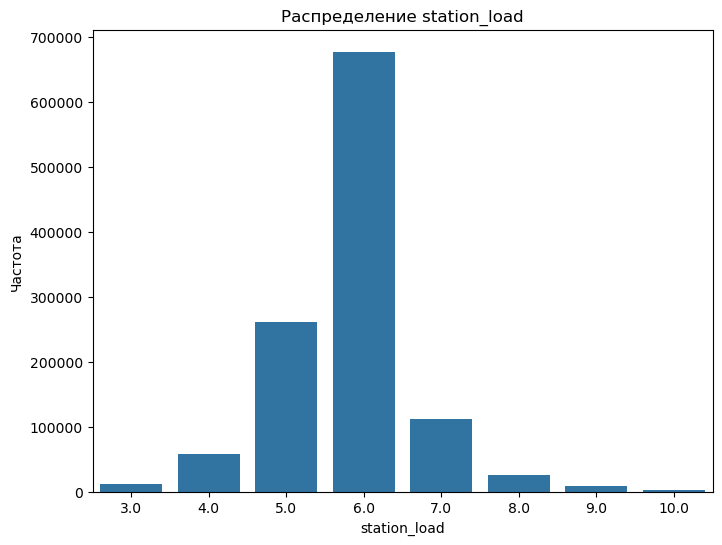

In [402]:
plt.figure(figsize=(8, 6))
sns.countplot(data=main_df, x='station_load')

plt.title('Распределение station_load')
plt.xlabel('station_load')
plt.ylabel('Частота')
plt.show()

In [79]:
#main_df.to_csv('output.csv', index=False)

## Развлекательные места в радиусе 5 км

In [448]:
def create_dataframe_from_api(url):
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()

        if isinstance(data, list):
            df = data
        else:
            df = data.get('results', [])

        df = pd.DataFrame(df)

        return df
    else:
        print(f"Ошибка: {response.status_code}")
        time.sleep(60)
        return create_dataframe_from_api(url)


In [450]:
coordinates = main_df[['lat', 'lon']].drop_duplicates()

In [452]:
all_places_dfs = []

for index, row in tqdm(coordinates.iterrows()):
    lat = row['lat']
    lon = row['lon']

    url = (f"https://kudago.com/public-api/v1.4/places/?lang="
           f"&fields=title,short_title,subway,favorites_count,categories"
           f"&page=1"
           f"&page_size=300"
           f"&location=msk"
           f"&lat={lat}"
           f"&lon={lon}"
           f"&radius=5000")

    places_df = create_dataframe_from_api(url)

    if places_df is not None:
        places_df['lat'] = lat
        places_df['lon'] = lon

        all_places_dfs.append(places_df)

if all_places_dfs:
    final_places_df = pd.concat(all_places_dfs, ignore_index=True)
else:
    final_places_df = pd.DataFrame()

132it [03:10,  1.44s/it]


In [453]:
final_count = final_places_df.groupby(['lat', 'lon'], as_index=False).title.count()
final_count.columns = ['lat', 'lon', 'number_of_places']

In [454]:
df_places = main_df.merge(final_count, on=['lat', 'lon'], how='left')

In [455]:
df_places.number_of_places = df_places.number_of_places.fillna(0)

In [456]:
df_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156320 entries, 0 to 1156319
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   timestamp              1156320 non-null  datetime64[ns]
 1   district_name          1156320 non-null  object        
 2   lat                    1156320 non-null  float64       
 3   lon                    1156320 non-null  float64       
 4   n_taxi_start           1156320 non-null  float64       
 5   n_taxi_end             1156320 non-null  float64       
 6   n_carsharing_start     1156320 non-null  float64       
 7   n_carsharing_end       1156320 non-null  float64       
 8   temperature            1156320 non-null  float64       
 9   precipitation          1156320 non-null  float64       
 10  humidity               1156320 non-null  float64       
 11  wind_speed             1156320 non-null  float64       
 12  weather_code           11563

In [457]:
main_df = df_places.copy()

## Добавление информации о населении районов и доступности метро

Источник информации:  https://atlas.itdp.org/

In [465]:
population = pd.read_csv('https://raw.githubusercontent.com/RuslanDavletov/Analysis-of-taxi-demand/main/data/population_and_metro_accessibility.csv')
population.head()

,Unnamed: 0,name,Unnamed: 1,city_popdensitytotal_2023,People Near Rapid Transport
0,0,Орехово-Борисово Южное,admin_level 8,103638.104588,0.453423
1,1,район Зябликово,admin_level 8,122347.500560,0.797626
2,2,район Братеево,admin_level 8,112284.785902,0.601530
3,3,район Капотня,admin_level 8,35090.913185,0.000000
4,4,район Марьино,admin_level 8,209950.278499,0.555872


In [466]:
population = population.drop('Unnamed: 0', axis=1)

In [467]:
# Преобразуем данные о населении в целочисленный формат
population['city_popdensitytotal_2023'] = population['city_popdensitytotal_2023'].astype('int')

In [471]:
# Добавляем информацию в основной датасет
df = main_df.merge(population,how='left', left_on='district_name', right_on='name')
df

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,...,is_holiday_or_weekend,quarter,station_load,station_load_norm,number_of_stations,number_of_places,name,Unnamed: 1,city_popdensitytotal_2023,People Near Rapid Transport
0,2024-01-01 00:00:00,Академический район,55.689537,37.576881,203.0,178.0,15.0,21.0,-11.1,0.0,...,1,I квартал,6.0,0.511902,1.0,123.0,Академический район,admin_level 8,117048,0.717789
1,2024-01-01 01:00:00,Академический район,55.689537,37.576881,417.0,355.0,11.0,14.0,-12.0,0.0,...,1,I квартал,6.0,0.511902,1.0,123.0,Академический район,admin_level 8,117048,0.717789
2,2024-01-01 02:00:00,Академический район,55.689537,37.576881,404.0,426.0,5.0,9.0,-12.4,0.0,...,1,I квартал,6.0,0.511902,1.0,123.0,Академический район,admin_level 8,117048,0.717789
3,2024-01-01 03:00:00,Академический район,55.689537,37.576881,381.0,415.0,6.0,6.0,-12.1,0.0,...,1,I квартал,6.0,0.511902,1.0,123.0,Академический район,admin_level 8,117048,0.717789
4,2024-01-01 04:00:00,Академический район,55.689537,37.576881,281.0,332.0,4.0,4.0,-12.7,0.0,...,1,I квартал,6.0,0.511902,1.0,123.0,Академический район,admin_level 8,117048,0.717789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313995,2024-12-30 19:00:00,район Ясенево,55.615635,37.537104,370.5,408.0,60.0,70.0,1.7,0.2,...,1,IV квартал,7.0,0.671097,4.0,33.0,район Ясенево,admin_level 8,188343,0.273423
1313996,2024-12-30 20:00:00,район Ясенево,55.615635,37.537104,367.0,408.0,53.0,59.0,1.7,0.2,...,1,IV квартал,7.0,0.671097,4.0,33.0,район Ясенево,admin_level 8,188343,0.273423
1313997,2024-12-30 21:00:00,район Ясенево,55.615635,37.537104,364.0,389.0,41.0,39.0,1.7,0.0,...,1,IV квартал,6.0,0.593452,4.0,33.0,район Ясенево,admin_level 8,188343,0.273423
1313998,2024-12-30 22:00:00,район Ясенево,55.615635,37.537104,304.5,357.5,38.0,51.0,1.1,0.0,...,1,IV квартал,6.0,0.593452,4.0,33.0,район Ясенево,admin_level 8,188343,0.273423


In [473]:
# Удаляем ненужные поля
df = df.drop(['name', 'Unnamed: 1'], axis=1)

# Переименовываем добавленные поля
df = df.rename(columns={'city_popdensitytotal_2023' : 'population_district_2023',
                        'People Near Rapid Transport': 'population_near_metro_percent'})

In [474]:
# Проверяем данные на дубликаты
df.duplicated().sum()

157680

In [475]:
# Удаляем найденные дубликаты
df = df.drop_duplicates()
df

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,...,rush_hour,season,is_holiday_or_weekend,quarter,station_load,station_load_norm,number_of_stations,number_of_places,population_district_2023,population_near_metro_percent
0,2024-01-01 00:00:00,Академический район,55.689537,37.576881,203.0,178.0,15.0,21.0,-11.1,0.0,...,0,0,1,I квартал,6.0,0.511902,1.0,123.0,117048,0.717789
1,2024-01-01 01:00:00,Академический район,55.689537,37.576881,417.0,355.0,11.0,14.0,-12.0,0.0,...,0,0,1,I квартал,6.0,0.511902,1.0,123.0,117048,0.717789
2,2024-01-01 02:00:00,Академический район,55.689537,37.576881,404.0,426.0,5.0,9.0,-12.4,0.0,...,0,0,1,I квартал,6.0,0.511902,1.0,123.0,117048,0.717789
3,2024-01-01 03:00:00,Академический район,55.689537,37.576881,381.0,415.0,6.0,6.0,-12.1,0.0,...,0,0,1,I квартал,6.0,0.511902,1.0,123.0,117048,0.717789
4,2024-01-01 04:00:00,Академический район,55.689537,37.576881,281.0,332.0,4.0,4.0,-12.7,0.0,...,0,0,1,I квартал,6.0,0.511902,1.0,123.0,117048,0.717789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313995,2024-12-30 19:00:00,район Ясенево,55.615635,37.537104,370.5,408.0,60.0,70.0,1.7,0.2,...,2,0,1,IV квартал,7.0,0.671097,4.0,33.0,188343,0.273423
1313996,2024-12-30 20:00:00,район Ясенево,55.615635,37.537104,367.0,408.0,53.0,59.0,1.7,0.2,...,0,0,1,IV квартал,7.0,0.671097,4.0,33.0,188343,0.273423
1313997,2024-12-30 21:00:00,район Ясенево,55.615635,37.537104,364.0,389.0,41.0,39.0,1.7,0.0,...,0,0,1,IV квартал,6.0,0.593452,4.0,33.0,188343,0.273423
1313998,2024-12-30 22:00:00,район Ясенево,55.615635,37.537104,304.5,357.5,38.0,51.0,1.1,0.0,...,0,0,1,IV квартал,6.0,0.593452,4.0,33.0,188343,0.273423


In [479]:
# Проверяем данные на пропуски
df.isna().sum().sum()

0

In [481]:
main_df = df.copy()

In [483]:
# Не процент, а доля
main_df.rename(columns={'population_near_metro_percent': 'population_near_metro'}, inplace=True)

In [485]:
main_df.shape

(1156320, 23)

## Цены на недвижимость по районам Москвы

In [491]:
#данные из парсера
estate_price = pd.read_csv('https://raw.githubusercontent.com/RuslanDavletov/Analysis-of-taxi-demand/main/data/moscow_estate_price_raw.csv')

In [492]:
#таблица со всеми районами из основного файла с поездками
districts = pd.DataFrame(main_df['district_name'].unique(), columns=['district_name'])

In [493]:
#проверяем тип данных
estate_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Район            146 non-null    object 
 1   Первичный рынок  137 non-null    float64
 2   Вторичный рынок  146 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.6+ KB


In [497]:
# для дальнейшего анализа будем использовать данные о стоимости жилья только на вторичном рынке
estate_price=estate_price[['Район','Вторичный рынок']]

In [498]:
#добавляем колонку, где будут только сами названия,без типа пункта
estate_price.loc[:, 'estate_name_clean'] = estate_price['Район'].replace(
    to_replace = ['[Рр]айон','поселение','городской округ'],
    value ='',
    regex = True
).str.strip(to_strip=None)

In [501]:
#тоже самое делаем в таблице districts
districts.loc[:, 'main_name_clean'] = districts['district_name'].replace(
    to_replace = ['[Рр]айон','поселение','городской округ'],
    value ='',
    regex = True
).str.strip(to_strip=None)

In [503]:
#districts['district_name'].unique()

In [505]:
#estate_price['Район'].unique()

In [507]:
#мерджим таблицу districts и estate_price по новым колонкам с названиями
merged_df = districts.merge(estate_price, how='left', left_on='main_name_clean', right_on='estate_name_clean')

In [509]:
#проверяем наличие пропусков
merged_df[merged_df['Вторичный рынок'].isna()]

,district_name,main_name_clean,Район,Вторичный рынок,estate_name_clean
13,Краснопахорский район,Краснопахорский,NaN,NaN,NaN
33,Филимонковский район,Филимонковский,NaN,NaN,NaN
40,район Бекасово,Бекасово,NaN,NaN,NaN
47,район Внуково,Внуково,NaN,NaN,NaN
48,район Вороново,Вороново,NaN,NaN,NaN
62,район Коммунарка,Коммунарка,NaN,NaN,NaN


Пропуски возникли из-за териториальных изменений Москвы в 2024 году:в таблице districts актуальные данные по районам, в таблице estate_price- устаревшие, обработаем эти пропуски вручную,используя также открытые источники (https://www.irn.ru/kvartiry/moskva/ceny-po-rayonam/?ysclid=m82cab41ua433689328)

In [512]:
#цены в р.Коммунарка совпадают с ценами в р.Южное Бутово
merged_df.loc[merged_df['district_name'] == 'район Коммунарка', 'Вторичный рынок'] = \
    estate_price.loc[estate_price['estate_name_clean'] == 'Южное Бутово', 'Вторичный рынок'].values[0]

#в таблице estate_price районы Филимонковский,Внуково,Вороново,Краснопахорски обозначены как поселения
#(Филимонковское,Внуковское,Вороновское,Краснопахорское) - окончания не совпадают,поэтому появились пропуски
merged_df.loc[
    merged_df['district_name'].isin({'Филимонковский район', 'район Внуково', 'район Вороново', 'Краснопахорский район'}),
    'Вторичный рынок'
] = merged_df['district_name'] \
    .replace({
        'Филимонковский район': 'Филимонковское',
        'район Внуково': 'Внуковское',
        'район Вороново': 'Вороновское',
        'Краснопахорский район': 'Краснопахорское'
    }) \
    .map(estate_price.set_index('estate_name_clean')['Вторичный рынок'])

#район Бекасово соответствует упраздненным поселениям Новофёдоровское и Киевский - возьмем среднее от их цен
merged_df.loc[merged_df['district_name'] == 'район Бекасово', 'Вторичный рынок'] = \
    estate_price.loc[estate_price['estate_name_clean'].isin(['Новофёдоровское', 'Киевский']), 'Вторичный рынок'].mean()

In [514]:
#проверяем наличие пропусков после обработки
merged_df[merged_df['Вторичный рынок'].isna()]

,district_name,main_name_clean,Район,Вторичный рынок,estate_name_clean


In [516]:
#дополнительно проверяем цены
merged_df[merged_df['Вторичный рынок'] ==  0]

,district_name,main_name_clean,Район,Вторичный рынок,estate_name_clean
105,район Силино,Силино,район Силино,0.0,Силино


In [518]:
#Силино относится к Зеленоградску,цены соответствуют Матушкино,Савелки и тд
merged_df.loc[merged_df['district_name'] == 'район Силино', 'Вторичный рынок'] = \
    estate_price.loc[estate_price['estate_name_clean'] == 'Матушкино', 'Вторичный рынок'].values[0]
#проверяем еще раз
merged_df[merged_df['Вторичный рынок'] ==  0]

,district_name,main_name_clean,Район,Вторичный рынок,estate_name_clean


In [520]:
#в финальной таблице сохраняем названия из main_df и соответствующие цены
msc_estate_price_final = merged_df[['district_name','Вторичный рынок']].rename(columns={'Вторичный рынок': 'price_m2'})

In [522]:
# Объединяем данные по столбцу 'district_name', добавляя столбец 'price_m2'
main_df = main_df.merge(msc_estate_price_final[['district_name', 'price_m2']], on='district_name', how='left')

In [523]:
(main_df.number_of_places % 1).unique()

array([0.])

In [524]:
main_df = main_df.astype({'n_taxi_start': int,
                'n_taxi_end': int,
                'n_carsharing_start': int,
                'n_carsharing_end': int,
                'humidity': int,
                'weather_code': int,
                'station_load': int,
                'number_of_stations': int,
                'number_of_places': int})

In [537]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156320 entries, 0 to 1156319
Data columns (total 24 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   timestamp                 1156320 non-null  datetime64[ns]
 1   district_name             1156320 non-null  object        
 2   lat                       1156320 non-null  float64       
 3   lon                       1156320 non-null  float64       
 4   n_taxi_start              1156320 non-null  int64         
 5   n_taxi_end                1156320 non-null  int64         
 6   n_carsharing_start        1156320 non-null  int64         
 7   n_carsharing_end          1156320 non-null  int64         
 8   temperature               1156320 non-null  float64       
 9   precipitation             1156320 non-null  float64       
 10  humidity                  1156320 non-null  int64         
 11  wind_speed                1156320 non-null  float6

## Добавление административных округов 

In [541]:
administrative_districts = {
    'Центральный': [
        'район Арбат', 'Басманный район', 'район Замоскворечье', 'Красносельский район', 
        'Мещанский район', 'Пресненский район', 'Таганский район', 'Тверской район', 
        'район Хамовники', 'район Якиманка'
    ],
    'Северный': [
        'район Аэропорт', 'район Беговой', 'Войковский район', 'Головинский район', 
        'Дмитровский район', 'район Коптево', 'район Левобережный', 'Молжаниновский район', 
        'Савёловский район', 'район Сокол', 'Тимирязевский район', 'район Ховрино', 
        'Хорошёвский район', 'Бескудниковский район', 'район Западное Дегунино', 
        'район Восточное Дегунино'
    ],
    'Северо-Восточный': [
        'Алексеевский район', 'Алтуфьевский район', 'Бабушкинский район', 'район Бибирево', 
        'Бутырский район', 'район Лианозово', 'Лосиноостровский район', 'район Марфино', 
        'район Марьина Роща', 'Останкинский район', 'район Отрадное', 'район Ростокино', 
        'район Свиблово', 'район Северный', 'Ярославский район', 'район Северное Медведково', 
        'район Южное Медведково'
    ],
    'Восточный': [
        'район Богородское', 'район Вешняки', 'район Восточный', 'район Гольяново', 
        'район Ивановское', 'район Измайлово', 'район Косино-Ухтомский', 'район Метрогородок', 
        'район Новогиреево', 'район Перово', 'район Преображенское', 'район Северное Измайлово', 
        'район Соколиная Гора', 'район Сокольники', 'район Новокосино', 'район Восточное Измайлово'
    ],
    'Юго-Восточный': [
        'район Выхино-Жулебино', 'район Капотня', 'район Кузьминки', 'район Лефортово', 
        'район Люблино', 'район Марьино', 'район Некрасовка', 'Нижегородский район', 
        'район Печатники', 'Рязанский район', 'район Текстильщики', 'Южнопортовый район'
    ],
    'Южный': [
        'район Бирюлёво Восточное', 'район Бирюлёво Западное', 'район Братеево', 
        'Даниловский район', 'Донской район', 'район Москворечье-Сабурово', 
        'район Нагатино-Садовники', 'район Нагатинский Затон', 'Нагорный район', 
        'район Орехово-Борисово Северное', 'Орехово-Борисово Южное', 'район Царицыно', 
        'район Чертаново Северное', 'район Чертаново Центральное', 'район Чертаново Южное', 
        'район Зябликово'
    ],
    'Юго-Западный': [
        'Академический район', 'Гагаринский район', 'район Зюзино', 'район Коньково', 
        'район Котловка', 'Ломоносовский район', 'Обручевский район', 'район Северное Бутово', 
        'район Тёплый Стан', 'район Черёмушки', 'район Южное Бутово', 'район Ясенево'
    ],
    'Западный': [
        'район Внуково', 'район Дорогомилово', 'район Крылатское', 'район Кунцево', 
        'Можайский район', 'Ново-Переделкино', 'район Очаково-Матвеевское', 
        'район Проспект Вернадского', 'район Раменки', 'район Солнцево', 
        'Тропарёво-Никулино', 'район Филёвский Парк', 'район Фили-Давыдково'
    ],
    'Северо-Западный': [
        'район Куркино', 'район Митино', 'район Покровское-Стрешнево', 
        'район Северное Тушино', 'район Строгино', 'район Хорошёво-Мнёвники', 
        'район Щукино', 'район Южное Тушино'
    ],
    'Зеленоградский': [
        'район Крюково', 'район Матушкино', 'район Савёлки', 'район Силино', 
        'район Старое Крюково'
    ],
    'Новомосковский': [
        'район Коммунарка', 'Филимонковский район'
    ],
    'Троицкий': [
        'район Бекасово', 'район Вороново', 'Краснопахорский район', 
        'район Троицк', 'район Щербинка'
    ]
}

In [543]:
# Добавляю допольнительно доп. признак - административный округ по районам для дальнейшего анализа 
district_to_okrug = {administrative_districts: okrug for okrug, districts_list in administrative_districts.items() for administrative_districts in districts_list}

main_df['administrative_region'] = main_df['district_name'].map(district_to_okrug)

In [547]:
main_df.sample(3)

,timestamp,district_name,lat,lon,n_taxi_start,n_taxi_end,n_carsharing_start,n_carsharing_end,temperature,precipitation,...,is_holiday_or_weekend,quarter,station_load,station_load_norm,number_of_stations,number_of_places,population_district_2023,population_near_metro,price_m2,administrative_region
518542,2024-03-11 22:00:00,район Ивановское,55.768188,37.825217,172,433,17,35,-0.8,0.0,...,0,I квартал,6,0.538750,2,23,123190,0.079479,216.6,Восточный
312587,2024-09-06 11:00:00,Южнопортовый район,55.714529,37.680478,358,363,56,46,22.4,0.0,...,0,III квартал,5,0.448806,2,215,54873,0.902339,309.3,Юго-Восточный
605808,2024-02-27 00:00:00,район Кузьминки,55.698515,37.775465,129,190,13,21,-4.0,0.0,...,0,I квартал,6,0.551694,1,25,125167,0.556934,242.5,Юго-Восточный


In [559]:
# Все пропуски обработаны
main_df.isna().sum().sum()

0

In [560]:
# Кол-во уникальных округов соответствует википедии
main_df.administrative_region.nunique()

12

In [563]:
# Кол-во записей неизменилось с момента формирования записей о поездах в самом начале
main_df.shape[0] == df_filled.shape[0]

True

In [566]:
# main_df.to_csv('main_df.csv', index=False)